# Libraries

In [5]:
from nequip.ase import NequIPCalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.filters import UnitCellFilter 
from ase.constraints import FixAtoms
from ase.io import Trajectory
import pickle
from ase.atoms import Atoms, units 
import numpy as np 
import json, os
from ase.optimize import LBFGS 
from pymatgen.core import Structure 

class TrajectoryObserver:
    """Trajectory observer is a hook in the relaxation process that saves the
    intermediate structures.
    """

    # thanks to CHGNet and M3GNET teams

    def __init__(self, atoms: Atoms) -> None:
        """Create a TrajectoryObserver from an Atoms object.

        Args:
            atoms (Atoms): the structure to observe.
        """
        self.atoms = atoms
        self.energies: list[float] = []
        self.forces: list[np.ndarray] = []
        #self.stresses: list[np.ndarray] = []
        #self.magmoms: list[np.ndarray] = []
        self.atom_positions: list[np.ndarray] = []
        self.cells: list[np.ndarray] = []

    def __call__(self) -> None:
        """The logic for saving the properties of an Atoms during the relaxation."""
        self.energies.append(self.compute_energy())
        self.forces.append(self.atoms.get_forces())
        #self.stresses.append(self.atoms.get_stress())
        #self.magmoms.append(self.atoms.get_magnetic_moments())
        self.atom_positions.append(self.atoms.get_positions())
        self.cells.append(self.atoms.get_cell()[:])

    def __len__(self) -> int:
        """The number of steps in the trajectory."""
        return len(self.energies)

    def compute_energy(self) -> float:
        """Calculate the potential energy.

        Returns:
            energy (float): the potential energy.
        """
        return self.atoms.get_potential_energy()

    def save(self, filename: str) -> None:
        """Save the trajectory to file.

        Args:
            filename (str): filename to save the trajectory
        """
        out_pkl = {
            "energy": self.energies,
            "forces": self.forces,
            #"stresses": self.stresses,
            #"magmoms": self.magmoms,
            "atom_positions": self.atom_positions,
            "cell": self.cells,
            "atomic_number": self.atoms.get_atomic_numbers(),
        }
        with open(filename, "wb") as file:
            pickle.dump(out_pkl, file)


def allegro_relaxer(atoms, potential_path, species, device='cpu', fmax = 0.01, steps = 250, verbose=False, relax_cell=True, loginterval=1):
    atoms.calc = NequIPCalculator.from_deployed_model(
        model_path=potential_path,
        species_to_type_name = species
    )
    
    if relax_cell:
        ucf = UnitCellFilter(atoms)
        obs = TrajectoryObserver(ucf)
        optimizer = LBFGS(ucf)
        optimizer.attach(obs, interval=loginterval)
        
    else:
        constraints = FixAtoms(mask=[False] * len(atoms))  # Allow all atoms to move
        # Add constraints to atoms
        atoms.set_constraint(constraints)

        obs = TrajectoryObserver(atoms)
        optimizer = LBFGS(atoms)
        optimizer.attach(obs, interval=loginterval)
    
    optimizer.run(fmax=fmax, steps=steps)
    struct = AseAtomsAdaptor.get_structure(atoms)
    return {"final_structure" : struct, "trajectory" : obs}

def numeric_stress(atoms, d=1e-6, voigt=True):
    stress = np.zeros((3, 3), dtype=float)

    cell = atoms.cell.copy()
    V = atoms.get_volume()
    for i in range(3):
        x = np.eye(3)
        x[i, i] += d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eplus = atoms.get_potential_energy(force_consistent=True)

        x[i, i] -= 2 * d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eminus = atoms.get_potential_energy(force_consistent=True)

        stress[i, i] = (eplus - eminus) / (2 * d * V)
        x[i, i] += d

        j = i - 2
        x[i, j] = d
        x[j, i] = d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eplus = atoms.get_potential_energy(force_consistent=True)

        x[i, j] = -d
        x[j, i] = -d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eminus = atoms.get_potential_energy(force_consistent=True)

        stress[i, j] = (eplus - eminus) / (4 * d * V)
        stress[j, i] = stress[i, j]
    atoms.set_cell(cell, scale_atoms=True)

    if voigt:
        return stress.flat[[0, 4, 8, 5, 2, 1]]
    else:
        return stress

def np_numeric_stress(atoms, d=1e-6, voigt=True):
    stress = np.zeros((3, 3), dtype=float)
    cell = atoms.cell.copy()
    V = atoms.get_volume()

    for i in range(3):
        x = np.eye(3)
        x[i, i] += d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eplus = atoms.get_potential_energy(force_consistent=True)
        
        x[i, i] -= 2 * d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eminus = atoms.get_potential_energy(force_consistent=True)
        
        stress[i, i] = (eplus - eminus) / (2 * d * V)
        x[i, i] += d
        
        for j in range(i + 1, 3):
            x[i, j] = d
            x[j, i] = d
            atoms.set_cell(np.dot(cell, x), scale_atoms=True)
            eplus = atoms.get_potential_energy(force_consistent=True)
            
            x[i, j] = -d
            x[j, i] = -d
            atoms.set_cell(np.dot(cell, x), scale_atoms=True)
            eminus = atoms.get_potential_energy(force_consistent=True)
            
            stress[i, j] = (eplus - eminus) / (4 * d * V)
            stress[j, i] = stress[i, j]
    
    atoms.set_cell(cell, scale_atoms=True)

    return stress

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 1.13.1 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(


# Run Code

In [33]:
# test the relaxing function
#load all the structures
# on pc
#data_path = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/gen_0_4/Vacancies/converted_vcrtiwzr_gen_0_4_vacancies_data.json'
# on mac 
#data_path = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/Vacancies/converted_vcrtiwzr_gen_0_4_vacancies_data.json'
data_path = '../Archived_Vasp_Jobs/VCrTiWZr_Summit/vacancies_parsed_data.json'
data = json.load(open(data_path, 'r'))

In [34]:
species = {
            "Ti": "NequIPTypeNameForTitanium",
            "V": "NequIPTypeNameForVanadium",
            "Cr" : "NequIPTypeNameForChromium",
            "Zr" : "NequIPTypeNameForZirconium",
            "W" : "NequIPTypeNameForTungsten",
        }

species = {"Ti" : "Ti", "V" : "V", "Cr" : "Cr", "Zr" : "Zr", "W" : "W"}

In [36]:
# get a structure
from pymatgen.core import Structure, Lattice 
#structure = Structure.from_dict(data['supercell_gen0_comp11_struct3_vac_site3_start']['structures'][-1])
structure_info = data['supercell_gen0_comp11_struct3_vac_site3_start']['structures'][-1]
structure = Structure(
        Lattice(structure_info['lattice']), 
        structure_info['species'], 
        structure_info['coords'], 
        coords_are_cartesian=structure_info['coords_are_cartesian'],
        to_unit_cell=structure_info['to_unit_cell']
    )

test_energy = data['supercell_gen0_comp11_struct3_vac_site3_start']['energies'][-1]
test_forces = data['supercell_gen0_comp11_struct3_vac_site3_start']['forces'][-1] 
test_stress = np.array(data['supercell_gen0_comp11_struct3_vac_site3_start']['stresses'][-1])

atoms = AseAtomsAdaptor.get_atoms(structure)

In [20]:
from pymatgen.core import Structure, Lattice
from pymatgen.io.vasp.inputs import Poscar 

# Lattice parameter
a = 3.01

# Rhombohedral lattice vectors for the primitive cell of a BCC lattice
lattice_vectors = [
    [0.5 * a, 0.5 * a, -0.5 * a],
    [0.5 * a, -0.5 * a, 0.5 * a],
    [-0.5 * a, 0.5 * a, 0.5 * a],
]

# Create the lattice
lattice = Lattice(lattice_vectors)

# Define the species and position for the single Vanadium atom in the primitive cell
species = ["V"]
position = [0, 0, 0]  # At the origin

# Create the structure
structure = Structure(lattice, species, [position])
for i in range(3,8):
    supercell = structure.copy()
    supercell.make_supercell([i, i, i])
    poscar = Poscar(supercell)
    poscar.write_file(f"new_POSCAR_{i*i*i}_atoms")


In [42]:
kb_to_ev_ang_3 = 0.00624150975
test_virial = -1 * test_stress * kb_to_ev_ang_3 * structure.volume
print(test_stress)
print(test_virial)
#print(test_virial.tolist())

[[-0.02959  0.02115 -0.00338]
 [ 0.02115 -0.00875  0.01259]
 [-0.00338  0.01259 -0.00939]]
[[ 0.16338712 -0.11678397  0.01866335]
 [-0.11678397  0.04831488 -0.06951821]
 [ 0.01866335 -0.06951821  0.05184877]]


In [50]:
atoms = AseAtomsAdaptor.get_atoms(structure)
pot_path = '../Potentials/fin_vcrtiwzr_novirial_efs.pth'
#relax_endpoint = allegro_relaxer(atoms, potential_path= pot_path , species = species , relax_cell= False)
atoms.calc = NequIPCalculator.from_deployed_model(
        model_path=pot_path,
        species_to_type_name = species,
        device='cpu'
    )

#print(atoms.get_potential_energy())
print(atoms.get_stress(voigt=False))
print(atoms.get_stress(voigt=False) - test_stress)
# test the difference between atoms.get_stress and the test_stress and the test_virial 
#print(atoms.get_stress(voigt=False) - test_stress/kb_to_ev_ang_3)
#print(atoms.get_stress(voigt=False) - test_stress*kb_to_ev_ang_3) # I forgot to convert from kb to ev_ang_3 oops 

import numpy as np

def percent_difference(array1, array2):
    # Ensure the input arrays are numpy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)
    
    # Calculate the percent difference
    percent_diff = np.abs(array1 - array2) / ((array1 + array2) / 2) * 100
    
    return percent_diff

print(percent_difference(atoms.get_stress(voigt=False), test_stress))
print(percent_difference(atoms.get_stress(voigt=False), test_virial))
print(percent_difference(atoms.get_stress(voigt=False), test_stress*kb_to_ev_ang_3))

[[ 0.00046354 -0.000395    0.00015838]
 [-0.000395    0.00239337 -0.00030534]
 [ 0.00015838 -0.00030534  0.00190024]]
[[ 0.03005354 -0.021545    0.00353838]
 [-0.021545    0.01114337 -0.01289534]
 [ 0.00353838 -0.01289534  0.01129024]]
[[-206.36584209  207.61262023 -219.66527607]
 [ 207.61262023 -350.60618933  209.94206405]
 [-219.66527607  209.94206405 -301.48495079]]
[[ 198.86839349 -198.65163571  196.63400009]
 [-198.65163571  181.12047095 -198.25080637]
 [ 196.63400009 -198.25080637  185.85839058]]
[[ 464.92571621 -400.77869934  261.46557529]
 [-400.77869934  209.34055531 -338.61663091]
 [ 261.46557529 -338.61663091  212.72950237]]


In [ ]:
nums = np.logspace(-7, 2, num=9)
for num in nums:
    stress = numeric_stress(atoms, d=num, voigt=False)
    #print(stress)
    #print(np.linalg.norm(stress - test_stress))
    mag_dif = np.abs(stress - test_stress)
    print("Step = ", num)
    print(mag_dif)
    #print("\n")
    

In [72]:
# benchmark stress and np stress
import time
import numpy as np

# Assuming `atoms` is already defined and has a calculator set as shown previously
# Define or import your functions `numeric_stress` and `np_numeric_stress` as needed

# Benchmark numeric_stress
start_time = time.time()
stress_tensor_numeric = numeric_stress(atoms, voigt=False)
time_numeric = time.time() - start_time

# Benchmark np_numeric_stress
start_time = time.time()
stress_tensor_np = np_numeric_stress(atoms)
time_np = time.time() - start_time

# Calculate the difference between the stress tensors
stress_difference = np.abs(stress_tensor_numeric - stress_tensor_np)

# Print the results
print(f"Time for numeric_stress: {time_numeric:.4f} seconds")
print(f"Time for np_numeric_stress: {time_np:.4f} seconds")
print(f"Difference between stress tensors: {stress_difference}")

Time for numeric_stress: 2.0849 seconds
Time for np_numeric_stress: 1.9206 seconds
Difference between stress tensors: [[0.         0.         0.00026443]
 [0.         0.         0.        ]
 [0.00026443 0.         0.        ]]


In [9]:
#print(atoms.get_forces())

# print the volume of the cell
print(atoms.get_volume())

from ase.constraints import FixAtoms
from ase.filters import UnitCellFilter
# Apply constraints to fix the cell
constraints = FixAtoms(mask=[False] * len(atoms))  # Allow all atoms to move

# Add constraints to atoms
atoms.set_constraint(constraints)

# Create a UnitCellFilter, but since the cell is fixed, it only affects atomic positions
#ucf = UnitCellFilter(atoms, mask=[False, False, False])

# Perform the relaxation
opt = LBFGS(atoms)
opt.run(fmax=0.01)  # Convergence criterion for forces in eV/Å

# Output the relaxed structure
print(atoms.get_volume())

884.6738653484483
       Step     Time          Energy          fmax
LBFGS:    0 12:55:34     -583.402457        0.039131
LBFGS:    1 12:55:34     -583.402732        0.038523
LBFGS:    2 12:55:36     -583.404353        0.031586
LBFGS:    3 12:55:36     -583.404451        0.030418
LBFGS:    4 12:55:36     -583.405127        0.018357
LBFGS:    5 12:55:36     -583.405225        0.020821
LBFGS:    6 12:55:36     -583.405376        0.026218
LBFGS:    7 12:55:36     -583.405530        0.021932
LBFGS:    8 12:55:36     -583.405682        0.014834
LBFGS:    9 12:55:36     -583.405766        0.020337
LBFGS:   10 12:55:36     -583.405831        0.017899
LBFGS:   11 12:55:36     -583.405902        0.017804
LBFGS:   12 12:55:37     -583.405975        0.014173
LBFGS:   13 12:55:37     -583.406018        0.014816
LBFGS:   14 12:55:37     -583.406043        0.015190
LBFGS:   15 12:55:37     -583.406071        0.009666
884.6738653484483


In [59]:
relaxed = allegro_relaxer(atoms, potential_path= pot_path , species = species , relax_cell= False)

       Step     Time          Energy          fmax
LBFGS:    0 16:16:14     -583.451897        0.028008
LBFGS:    1 16:16:15     -583.452094        0.024919
LBFGS:    2 16:16:15     -583.453019        0.030159
LBFGS:    3 16:16:15     -583.453073        0.026159
LBFGS:    4 16:16:15     -583.453285        0.011257
LBFGS:    5 16:16:15     -583.453311        0.015394
LBFGS:    6 16:16:16     -583.453376        0.017373
LBFGS:    7 16:16:16     -583.453410        0.011784
LBFGS:    8 16:16:16     -583.453436        0.007593


In [32]:
#from ase.calculators.test import numeric_stress 
print(numeric_stress(atoms))

884.6738653484483
[-0.00396188  0.00032333 -0.00020627  0.00108414 -0.00030494 -0.00027663]


In [33]:
comp_stress = numeric_stress(atoms, voigt=False)
print(comp_stress)  

884.6738653484483
[[-0.00396188 -0.00027663 -0.00030494]
 [-0.00027663  0.00032333  0.00108414]
 [-0.00030494  0.00108414 -0.00020627]]


In [42]:
#print(test_stress)
#multiplied_list = [[element / 10 for element in sublist] for sublist in test_stress]
difference = np.array(test_stress)/10 - np.array(comp_stress)
print(np.array(test_stress)/10)
print(np.array(comp_stress))
print(difference)
#for i in range(3): 
    #for j in range(3):
        

[[-0.002959  0.002115 -0.000338]
 [ 0.002115 -0.000875  0.001259]
 [-0.000338  0.001259 -0.000939]]
[[-0.00396188 -0.00027663 -0.00030494]
 [-0.00027663  0.00032333  0.00108414]
 [-0.00030494  0.00108414 -0.00020627]]
[[ 1.00287768e-03  2.39163236e-03 -3.30581433e-05]
 [ 2.39163236e-03 -1.19832942e-03  1.74863358e-04]
 [-3.30581433e-05  1.74863358e-04 -7.32731840e-04]]


In [37]:
np_stress = np.array(test_stress)
print(np_stress)
print(np_stress*10)

[[-0.02959  0.02115 -0.00338]
 [ 0.02115 -0.00875  0.01259]
 [-0.00338  0.01259 -0.00939]]
[[-0.2959  0.2115 -0.0338]
 [ 0.2115 -0.0875  0.1259]
 [-0.0338  0.1259 -0.0939]]


In [25]:
# need to create vasp job for the relaxed structure 
initial_structure = Structure.from_dict(data['supercell_gen0_comp11_struct3_vac_site3_start']['structures'][0])

# make a POSCAR file for this 
from pymatgen.io.vasp.inputs import Poscar
poscar = Poscar(initial_structure)
poscar.write_file('test_stress_POSCAR')

In [ ]:
vcrti_data = json.load(open('../Visualization/Job_Structures/Post_VASP/VCrTi/shuffled_vacancies_data.json'))


# Compare Stress Tensor from Allegro and VASP 

In [ ]:
# first we need to load in the data for the vcrti system 

# next we need to get the structures for the vcrti system 

# next we need to calculate the stress tensor for the structure and compare it to the stress tensor from the data? 
# what ase parameters should we use to calculate the stress tensor? should I just fix the atoms and cell and call the get_stress() function?
# or should I just start from the initial structure and let it relax? to do this I would need to go through the initial json file with all the structure ids 
# and then get the first structure and then relax it and then get the stress tensor and compare it to the stress tensor from the data.
# let's first just fix the atoms and cell and calculate the stress tensor and compare it to the stress tensor from the data.

# Compare the Volume between VCrtiWZr Perfect and Vacancies 

In [17]:
perfect_data = json.load(open('../Archived_Vasp_Jobs/perfect_parsed_data.json'))
vacancy_data = json.load(open('../Archived_Vasp_Jobs/vacancies_parsed_data.json'))

In [19]:
print(perfect_data.keys())
print(vacancy_data.keys())

dict_keys(['supercell_gen2_comp25_struct3', 'supercell_gen2_comp23_struct3', 'supercell_gen4_comp46_struct3', 'supercell_gen1_comp21_struct1', 'supercell_gen4_comp52_struct3', 'supercell_gen4_comp43_struct1', 'supercell_gen0_comp3_struct3', 'supercell_gen0_comp8_struct1', 'supercell_gen1_comp14_struct2', 'supercell_gen3_comp37_struct2', 'supercell_gen2_comp31_struct1', 'supercell_gen4_comp52_struct2', 'supercell_gen4_comp48_struct1', 'supercell_gen2_comp28_struct3', 'supercell_gen2_comp27_struct2', 'supercell_gen0_comp9_struct2', 'supercell_gen2_comp26_struct3', 'supercell_gen3_comp41_struct3', 'supercell_gen0_comp5_struct1', 'supercell_gen0_comp11_struct2', 'supercell_gen1_comp16_struct2', 'supercell_gen1_comp13_struct2', 'supercell_gen1_comp17_struct1', 'supercell_gen4_comp48_struct2', 'supercell_gen4_comp48_struct3', 'supercell_gen2_comp30_struct3', 'supercell_gen3_comp36_struct2', 'supercell_gen3_comp34_struct3', 'supercell_gen3_comp39_struct3', 'supercell_gen0_comp4_struct2', 'sup

In [26]:
print((perfect_data['supercell_gen0_comp11_struct3']['structures'][-1].keys()))

dict_keys(['lattice', 'species', 'coords', 'coords_are_cartesian', 'to_unit_cell'])


In [39]:
from pymatgen.core import Structure, Lattice 
def extract_numbers(key):
    parts = key.split('_')
    gen = parts[1][3:]
    comp = parts[2][4:]
    struct = parts[3][6:]
    return gen, comp, struct

from pymatgen.core import Structure, Lattice
import numpy as np
import matplotlib.pyplot as plt
import json

# Initialize a list to store all comparison data
comparison_data = []

# Iterate through perfect_data
for key in perfect_data:
    gen, comp, struct = extract_numbers(key)
    
    # Extract structure information from perfect_data
    structure_info = perfect_data[key]['structures'][-1]
    perfect_structure = Structure(
        Lattice(structure_info['lattice']), 
        structure_info['species'], 
        structure_info['coords'], 
        coords_are_cartesian=structure_info['coords_are_cartesian'],
        to_unit_cell=structure_info['to_unit_cell']
    )
    perfect_volume = perfect_structure.volume
    
    # Iterate through vacancy_data to find matching keys
    for v_key in vacancy_data:
        v_gen, v_comp, v_struct = extract_numbers(v_key)
        
        # Check if gen, comp, and struct match
        if gen == v_gen and comp == v_comp and struct == v_struct:
            # Extract structure information from vacancy_data
            vacancy_structure_info = vacancy_data[v_key]['structures'][-1]
            vacancy_structure = Structure(
                Lattice(vacancy_structure_info['lattice']), 
                vacancy_structure_info['species'], 
                vacancy_structure_info['coords'], 
                coords_are_cartesian=vacancy_structure_info['coords_are_cartesian'],
                to_unit_cell=vacancy_structure_info['to_unit_cell']
            )
            vacancy_volume = vacancy_structure.volume
            
            # Calculate volume difference and percent difference
            diff = abs(perfect_volume - vacancy_volume)
            percent_diff = (diff / perfect_volume) * 100
            
            # Append data for this comparison to the list
            comparison_data.append({
                "key": key,
                "perfect_structure": perfect_structure.as_dict(),
                "vacancy_structure": vacancy_structure.as_dict(),
                "volume_difference": diff,
                "percent_difference": percent_diff,
                "perf_composition": structure_info['species'],
                "vac_composition": vacancy_structure_info['species']
            })

# Write comparison data to a JSON file
with open('volume_comparison_data.json', 'w') as f:
    json.dump(comparison_data, f, indent=4)

Mean volume difference: 17.173185588214352
Standard deviation of volume difference: 15.85788020119575


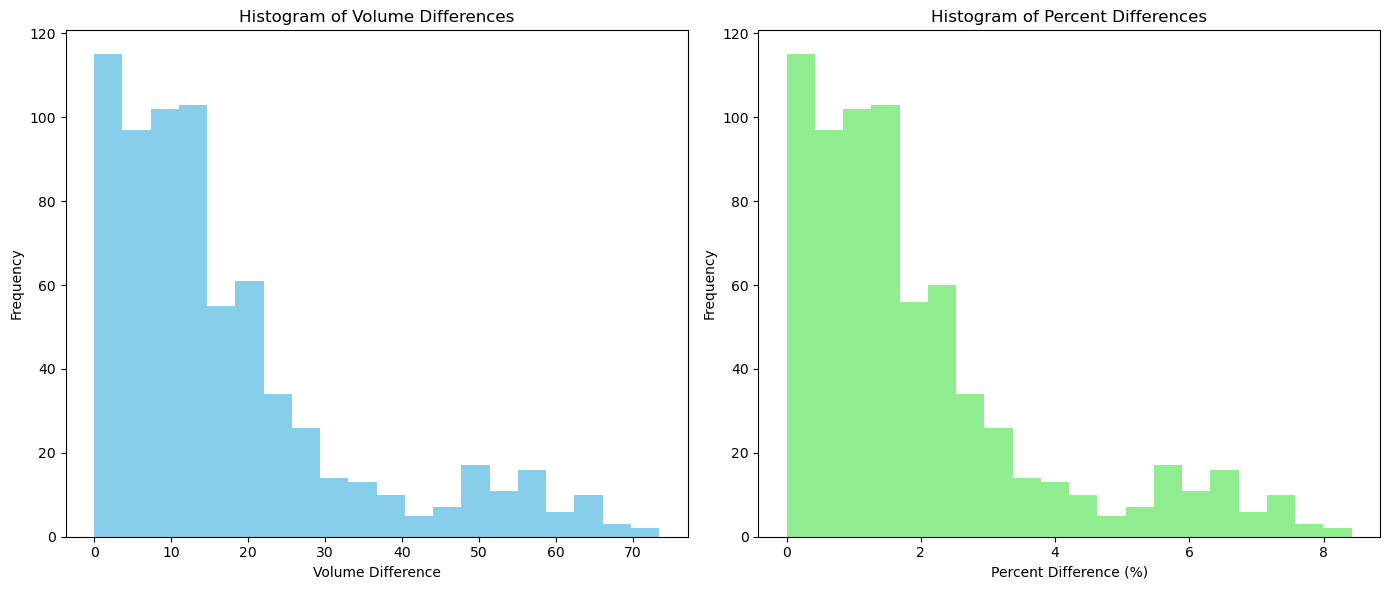

In [34]:
# Separate the differences and percent differences
differences = [data['volume_difference'] for data in comparison_data]
percent_differences = [data['percent_difference'] for data in comparison_data]
#percent_differences = zip(*volume_differences)

# Compute mean and standard deviation
mean_difference = np.mean(differences)
std_deviation = np.std(differences)

print(f"Mean volume difference: {mean_difference}")
print(f"Standard deviation of volume difference: {std_deviation}")

# Plotting
plt.figure(figsize=(14, 6))

# Histogram of volume differences
plt.subplot(1, 2, 1)
plt.hist(differences, bins=20, color='skyblue')
plt.title('Histogram of Volume Differences')
plt.xlabel('Volume Difference')
plt.ylabel('Frequency')

# Histogram of percent differences
plt.subplot(1, 2, 2)
plt.hist(percent_differences, bins=20, color='lightgreen')
plt.title('Histogram of Percent Differences')
plt.xlabel('Percent Difference (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [45]:
from collections import Counter
# I want to plot the composition, and data key of all the structures that have a volume difference greater than 5% 
# I want to see if there is a pattern in the compositions of the structures that have a large volume difference

# Extract keys and composition of structures with volume differences greater than 5%
keys = [data['key'] for data in comparison_data if data['percent_difference'] > 5]
compositions = [[data['perf_composition'], data['vac_composition']] for data in comparison_data if data['percent_difference'] > 5]

formatted_compositions = []
for composition in compositions:
    perf_element_count = Counter(composition[0])
    vac_element_count = Counter(composition[1])
    perf_sorted_elements = sorted(perf_element_count.items(), key=lambda x: x[1], reverse=True)
    vac_sorted_elements = sorted(vac_element_count.items(), key=lambda x: x[1], reverse=True)

    # if the number of unique elements the perfect and vacancy compositions are different, print the formatted_string of both the perfect and vacancy composition
    #if len(perf_sorted_elements) != len(vac_sorted_elements):
    perf_formatted_string = '-'.join([f"{element}:{count}" for element, count in perf_sorted_elements])
    vac_formatted_string = '-'.join([f"{element}:{count}" for element, count in vac_sorted_elements])
    formatted_compositions.append((perf_formatted_string, vac_formatted_string))
    print(f"Perfect: {perf_formatted_string} vs. Vacancy: {vac_formatted_string}")
        #print(f"Vacancy: {vac_formatted_string}")
    print("\n")

    #formatted_string = '-'.join([f"{element}:{count}" for element, count in sorted_elements])
    #print(formatted_string)


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:45-Zr:6-Ti:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:45-Ti:7-Zr:6-Cr:4-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:38-Ti:9-Cr:7-Zr:6-W:4 vs. Vacancy: V:37-Ti:9-Cr:7-Zr:6-W:4


Perfect: V:38-Ti:9-Cr:7-Zr:6-W:4 vs. Vacancy: V:38-Ti:9-Zr:6-Cr:6-W:4


Perfect: V:38-Ti:9-Cr:7-Zr:6-W:4 vs. Vacancy: V:38-Ti:9-Cr:7-Zr:5-W:4


Perfect: V:38-Ti:9-Cr:7-Zr:6-W:4 vs. Vacancy: V:37-Ti:9-Cr:7-Zr:6-W:4


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:45-Ti:7-Zr:6-Cr:4-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:48-Ti:8-Zr:4-Cr:3-W:1 vs. Vacancy: V:48-Ti:8-Zr:4-Cr:

In [47]:
import pandas as pd

# Define the compositions
compositions = [
    ('V:45-Ti:7-Zr:6-Cr:5-W:1', 'V:44-Ti:7-Zr:6-Cr:5-W:1'),
    ('V:45-Ti:7-Zr:6-Cr:5-W:1', 'V:45-Zr:6-Ti:6-Cr:5-W:1'),
    # Add all other compositions here
]

# Function to parse the compositions
def parse_composition(composition):
    try:
        elements = composition.split("-")
        return {el.split(":")[0]: int(el.split(":")[1]) for el in elements}
    except IndexError:
        print(f"Error parsing composition: {composition}")
        return {}

# Create a DataFrame
data = []
for perfect, vacancy in compositions:
    perfect_comp = parse_composition(perfect)
    vacancy_comp = parse_composition(vacancy)
    if perfect_comp and vacancy_comp:  # Only append if parsing was successful
        data.append({**perfect_comp, **{'Type': 'Perfect'}})
        data.append({**vacancy_comp, **{'Type': 'Vacancy'}})

df = pd.DataFrame(data)

# Fill missing elements with zeros
elements = ['V', 'Ti', 'Zr', 'Cr', 'W']
df = df.fillna(0)
df = df[elements + ['Type']]

df.head()



,V,Ti,Zr,Cr,W,Type
0,45,7,6,5,1,Perfect
1,44,7,6,5,1,Vacancy
2,45,7,6,5,1,Perfect
3,45,6,6,5,1,Vacancy


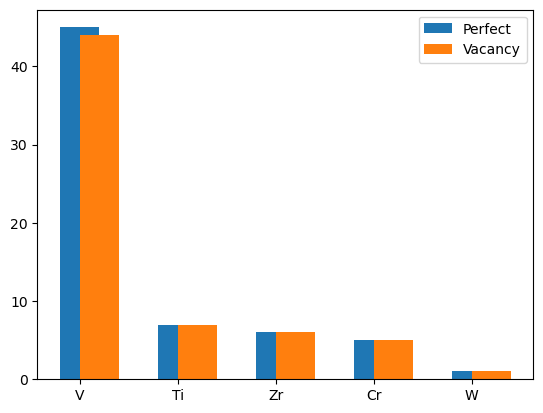

In [48]:
import matplotlib.pyplot as plt

# Function to plot bar charts
def plot_composition_bar(df, index):
    df_perfect = df[df['Type'] == 'Perfect'].iloc[index][:-1]
    df_vacancy = df[df['Type'] == 'Vacancy'].iloc[index][:-1]
    
    labels = df.columns[:-1]
    perfect_vals = df_perfect.values
    vacancy_vals = df_vacancy.values

    x = range(len(labels))

    fig, ax = plt.subplots()
    ax.bar(x, perfect_vals, width=0.4, label='Perfect', align='center')
    ax.bar(x, vacancy_vals, width=0.4, label='Vacancy', align='edge')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

# Plot the first composition pair as an example
plot_composition_bar(df, 0)


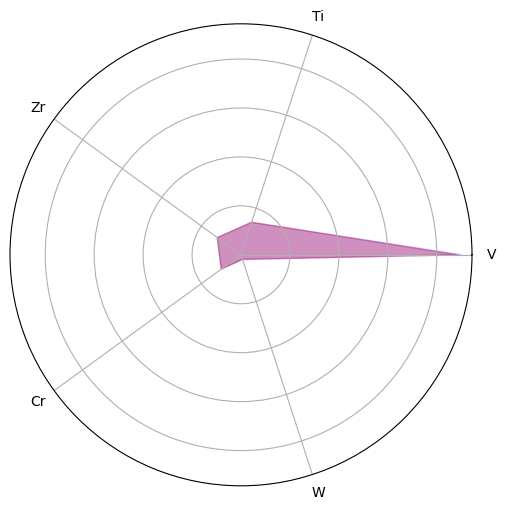

In [49]:
import numpy as np

# Function to plot radar charts
def plot_composition_radar(df, index):
    df_perfect = df[df['Type'] == 'Perfect'].iloc[index][:-1]
    df_vacancy = df[df['Type'] == 'Vacancy'].iloc[index][:-1]
    
    labels = df.columns[:-1]
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    perfect_vals = df_perfect.values.tolist()
    perfect_vals += perfect_vals[:1]
    
    vacancy_vals = df_vacancy.values.tolist()
    vacancy_vals += vacancy_vals[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, perfect_vals, color='blue', alpha=0.25)
    ax.fill(angles, vacancy_vals, color='red', alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.show()

# Plot the first composition pair as an example
plot_composition_radar(df, 0)


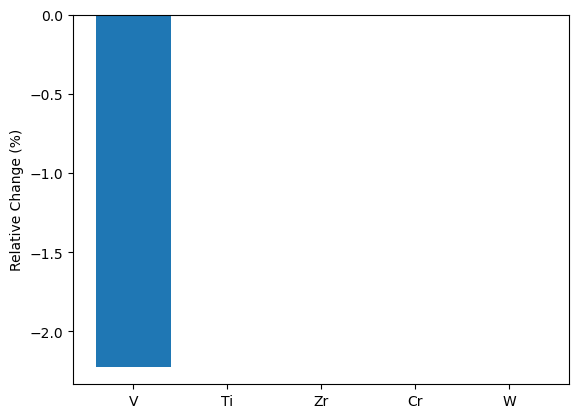

In [50]:
# Function to calculate and plot relative changes
def plot_relative_change(df, index):
    df_perfect = df[df['Type'] == 'Perfect'].iloc[index][:-1]
    df_vacancy = df[df['Type'] == 'Vacancy'].iloc[index][:-1]
    
    relative_change = (df_vacancy - df_perfect) / df_perfect * 100
    labels = df.columns[:-1]
    values = relative_change.values

    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_ylabel('Relative Change (%)')
    plt.show()

# Plot the relative change for the first composition pair as an example
plot_relative_change(df, 0)


# Test NEB

In [51]:
# first need to load in a perfect supercell 
structure_info = perfect_data['supercell_gen0_comp11_struct3']['structures'][-1]
perfect_structure = Structure(
        Lattice(structure_info['lattice']), 
        structure_info['species'], 
        structure_info['coords'], 
        coords_are_cartesian=structure_info['coords_are_cartesian'],
        to_unit_cell=structure_info['to_unit_cell']
)

In [53]:
# now i load in the defect maker library and add the ../Modules directory to the path
import sys
sys.path.append('../Modules')
from defect_maker import * 


In [55]:
# now we need to pick a random site from perfect_structure 
site_number = 25 
alat = perfect_structure.lattice.a
nearest_neighbors = return_x_neighbors(structure = perfect_structure, target_atom_index= site_number, x_neighbor=1, alat = alat) 
next_nearest_neighbors = return_x_neighbors(structure = perfect_structure, target_atom_index= site_number, x_neighbor=2, alat = alat)
print(nearest_neighbors)
print(next_nearest_neighbors)

([21, 58, 61, 59, 11, 41, 24, 0], [2.5601652691902177, 2.594451530275561, 2.5964873514189653, 2.599169372266476, 2.668398756895845, 2.6830280281893195, 2.7157403669550395, 2.758557973235984])
([38, 7, 57, 28, 1, 10], [2.98793145108502, 2.997024313140125, 3.01588354734476, 3.125093906107472, 3.1367353510307785, 3.158238031833226])


In [56]:
# now make start and end points
start, end = make_defects(structure = perfect_structure.copy(), target_atom_index= 25, vac_site = 21)

In [78]:
# test interpolate 
from ase.mep import DyNEB 
from ase.optimize import LBFGS 

calculator = NequIPCalculator.from_deployed_model(
        model_path=pot_path,
        species_to_type_name = species,
        device='cuda'
    )
start_atoms = AseAtomsAdaptor.get_atoms(start)
end_atoms = AseAtomsAdaptor.get_atoms(end)
print(start_atoms.get_volume())
print(end_atoms.get_volume())
# relax the start and end points 
#start_atoms.calc = calculator
#end_atoms.calc = calculator
allegro_relaxer(start_atoms, potential_path= pot_path , species = species , device = 'cuda', fmax = 0.05, relax_cell= False)
allegro_relaxer(end_atoms, potential_path= pot_path , species = species , device = 'cuda', fmax = 0.05, relax_cell= False)

images = [start_atoms]
images += [start_atoms.copy() for i in range(5)]
images += [end_atoms]
neb = DyNEB(images, allow_shared_calculator=True)
neb.interpolate(mic=True)
for image in images[1:6]:
    image.calc = calculator 

optimizer = LBFGS(neb)
optimizer.run(fmax=0.05)

872.6688946280925
872.6688946280925
       Step     Time          Energy          fmax
LBFGS:    0 14:58:47     -583.225893        0.934555
LBFGS:    1 14:58:47     -583.286669        0.944503
LBFGS:    2 14:58:48     -583.736550        0.918299
LBFGS:    3 14:58:49     -583.773706        0.847243
LBFGS:    4 14:58:49     -583.929583        0.355117
LBFGS:    5 14:58:49     -583.943901        0.317296
LBFGS:    6 14:58:49     -584.002080        0.340446
LBFGS:    7 14:58:49     -584.040920        0.383070
LBFGS:    8 14:58:49     -584.071750        0.257261
LBFGS:    9 14:58:49     -584.091317        0.270294
LBFGS:   10 14:58:49     -584.099614        0.226726
LBFGS:   11 14:58:49     -584.111381        0.160098
LBFGS:   12 14:58:49     -584.118704        0.125983
LBFGS:   13 14:58:50     -584.122039        0.137102
LBFGS:   14 14:58:50     -584.124317        0.130849
LBFGS:   15 14:58:50     -584.126853        0.084746
LBFGS:   16 14:58:50     -584.128801        0.095881
LBFGS:   17 

True

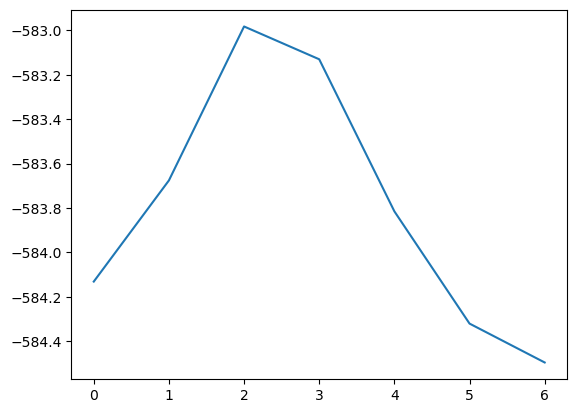

In [79]:
# print the energies of the images
energies = [image.get_potential_energy() for image in images]
images = np.arange(0, 7, 1)
plt.plot(images, energies)
plt.show()

In [71]:
# fully relax the start and end points 
start_relaxed = allegro_relaxer(AseAtomsAdaptor.get_atoms(start), pot_path, species, fmax= 0.05, relax_cell=True)
end_relaxed = allegro_relaxer(AseAtomsAdaptor.get_atoms(end), pot_path, species, fmax = 0.05, relax_cell=True)


       Step     Time          Energy          fmax
LBFGS:    0 14:34:40     -583.225893        0.934555


/home/myless/.mambaforge/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:59: UserWarning: !! Upstream issues in PyTorch versions >1.11 have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. At present we *strongly* recommend the use of PyTorch 1.11 if using CUDA devices; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/home/myless/.mambaforge/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:103: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


LBFGS:    1 14:34:40     -583.286963        0.944464
LBFGS:    2 14:34:41     -583.739753        0.916891
LBFGS:    3 14:34:41     -583.777160        0.845495
LBFGS:    4 14:34:42     -583.935327        0.355961
LBFGS:    5 14:34:42     -583.950123        0.316473
LBFGS:    6 14:34:42     -584.011073        0.347528
LBFGS:    7 14:34:42     -584.050724        0.392496
LBFGS:    8 14:34:42     -584.083846        0.261388
LBFGS:    9 14:34:42     -584.104298        0.280982
LBFGS:   10 14:34:42     -584.113291        0.236231
LBFGS:   11 14:34:42     -584.126511        0.170015
LBFGS:   12 14:34:42     -584.134877        0.133794
LBFGS:   13 14:34:42     -584.138985        0.153938
LBFGS:   14 14:34:43     -584.142064        0.150802
LBFGS:   15 14:34:43     -584.145765        0.102728
LBFGS:   16 14:34:43     -584.149012        0.123771
LBFGS:   17 14:34:43     -584.151227        0.093265
LBFGS:   18 14:34:43     -584.152911        0.108524
LBFGS:   19 14:34:43     -584.154838        0.

In [75]:
print(AseAtomsAdaptor.get_atoms(start_relaxed['final_structure']).get_volume())
print(AseAtomsAdaptor.get_atoms(end_relaxed['final_structure']).get_volume())

929.9410498699771
782.4107606288998


In [73]:
images = [AseAtomsAdaptor.get_atoms(start_relaxed['final_structure'])]
images += [AseAtomsAdaptor.get_atoms(start_relaxed['final_structure']).copy() for i in range(5)]
images += [AseAtomsAdaptor.get_atoms(end_relaxed['final_structure'])]
neb = DyNEB(images, allow_shared_calculator=True)
neb.interpolate(mic=True)
for image in images[1:6]:
    image.calc = calculator 

optimizer = LBFGS(neb)
optimizer.run(fmax=0.05)

NotImplementedError: Variable cell in periodic directions is not implemented yet for NEB

# Compare AIMD Parameters


In [22]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the pickle file
with open('/Users/myless/Downloads/dataframes.pkl', 'rb') as f:
    new_dataframes = pickle.load(f)

# Extract temperature data with the ability to specify a starting timestep
def extract_temperature_data(dataframes, start_timestep=50):
    temperature_data = {}
    for name, df in dataframes:
        gamma_value = int(name.split('-')[-1])
        temperatures = df['Temperature'].values[start_timestep:]
        temperature_data[gamma_value] = temperatures
    return temperature_data

# Specify the starting timestep
start_timestep = 50

# Extract temperature data
new_temperature_data = extract_temperature_data(new_dataframes, start_timestep)

# Target temperature
target_temperature = 300

# Initialize a dictionary to hold the new analysis results
new_analysis_results = {}

# Perform the analysis
for gamma, temperatures in new_temperature_data.items():
    mean_temp = np.mean(temperatures)
    std_temp = np.std(temperatures)
    rmsd_temp = np.sqrt(np.mean((temperatures - target_temperature) ** 2))
    
    new_analysis_results[gamma] = {
        'mean': mean_temp,
        'std': std_temp,
        'rmsd': rmsd_temp
    }

# Convert the results to a DataFrame for better visualization
df_new_analysis = pd.DataFrame(new_analysis_results).T
df_new_analysis = df_new_analysis.sort_index()  # Sort by Langevin_gamma_l values

# Save analysis results to CSV file
df_new_analysis.to_csv('new_temperature_analysis_results.csv')

# Plot Mean Temperature
plt.figure(figsize=(10, 6))
plt.plot(df_new_analysis.index, df_new_analysis['mean'], marker='o', label='Mean Temperature')
plt.axhline(target_temperature, color='r', linestyle='--', label='Target Temperature (300 K)')
plt.xlabel('Langevin_gamma_l')
plt.ylabel('Temperature (K)')
plt.title('Mean Temperature vs. Langevin_gamma_l')
plt.legend()
plt.grid(True)
plt.savefig('mean_temperature_plot.png')
plt.close()

# Plot Standard Deviation
plt.figure(figsize=(10, 6))
plt.plot(df_new_analysis.index, df_new_analysis['std'], marker='o', label='Standard Deviation')
plt.xlabel('Langevin_gamma_l')
plt.ylabel('Standard Deviation (K)')
plt.title('Standard Deviation of Temperature vs. Langevin_gamma_l')
plt.legend()
plt.grid(True)
plt.savefig('standard_deviation_plot.png')
plt.close()

# Plot RMSD
plt.figure(figsize=(10, 6))
plt.plot(df_new_analysis.index, df_new_analysis['rmsd'], marker='o', label='RMSD')
plt.xlabel('Langevin_gamma_l')
plt.ylabel('RMSD (K)')
plt.title('RMSD of Temperature vs. Langevin_gamma_l')
plt.legend()
plt.grid(True)
plt.savefig('rmsd_plot.png')
plt.close()


/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divi

# Create Compositions and relax with Allegro

## create the compositions

In [11]:
from pymatgen.core import Structure, Lattice, Element
import random
from ase.optimize import LBFGS, FIRE, BFGS, MDMin, QuasiNewton
from ase.filters import FrechetCellFilter 
from pymatgen.transformations.standard_transformations import PerturbStructureTransformation
from mace.calculators import MACECalculator
import json


def _create_random_bcc_supercell(composition, supercell_size):
    """
    Create a randomly ordered BCC supercell based on the given composition and supercell size.

    Parameters:
    composition (dict): Dictionary with elements as keys and their atomic fractions as values.
    supercell_size (tuple): Tuple representing the dimensions of the supercell (e.g., (5, 5, 5)).

    Returns:
    Structure: Pymatgen Structure object representing the randomly ordered supercell.
    """
    # Step 1: Define BCC primitive lattice
    lattice = Lattice([[0.5, 0.5, -0.5], [-0.5, 0.5, 0.5], [0.5, -0.5, 0.5]])

    # Step 2: Create a primitive BCC structure with a placeholder atom 'X'
    structure = Structure(lattice, ["X"], [[0, 0, 0]])

    # Step 3: Calculate the total number of atoms in the supercell
    total_atoms = supercell_size[0] * supercell_size[1] * supercell_size[2]

    # Step 4: Calculate the number of atoms of each type
    element_counts = {el: int(round(fraction * total_atoms)) for el, fraction in composition.items()}

    # Adjust the count of the last element to ensure the total number of atoms is correct
    counted_atoms = sum(element_counts.values())
    difference = total_atoms - counted_atoms
    if difference != 0:
        # Find the element with the highest fractional part for adjustment
        adjustments = {el: (fraction * total_atoms) - int(fraction * total_atoms) for el, fraction in composition.items()}
        if difference > 0:
            # Add atoms to the element with the highest fractional remainder
            element_to_adjust = max(adjustments, key=adjustments.get)
        else:
            # Remove atoms from the element with the lowest fractional remainder
            element_to_adjust = min(adjustments, key=adjustments.get)
        element_counts[element_to_adjust] += difference

    # Step 5: Generate a list of atoms based on composition
    atoms = []
    for element, count in element_counts.items():
        atoms.extend([element] * count)
    random.shuffle(atoms)  # Randomly order the atoms

    # Step 6: Create the supercell
    supercell = structure * supercell_size

    # Step 7: Assign atoms to the supercell
    for i, site in enumerate(supercell):
        site.species = Element(atoms[i])

    return supercell.get_sorted_structure()

def create_random_bcc_supercell(composition, supercell_size, lattice_parameter=3.01):
    """
    Create a randomly ordered BCC supercell based on the given composition and supercell size.

    Parameters:
    composition (dict): Dictionary with elements as keys and their atomic fractions as values.
    supercell_size (tuple): Tuple representing the dimensions of the supercell (e.g., (5, 5, 5)).
    lattice_parameter (float): The lattice parameter for the BCC lattice.

    Returns:
    Structure: Pymatgen Structure object representing the randomly ordered supercell.
    """
    # Step 1: Define BCC primitive lattice
    a = lattice_parameter
    lattice = Lattice.cubic(a)

    # Step 2: Create a primitive BCC structure with the first element in the composition
    initial_element = list(composition.keys())[0]
    structure = Structure(lattice, [initial_element], [[0, 0, 0]])

    # Step 3: Create the supercell
    supercell = structure * supercell_size

    # Step 4: Calculate the total number of atoms in the supercell
    total_atoms = supercell_size[0] * supercell_size[1] * supercell_size[2]

    # Step 5: Calculate the number of atoms of each type
    element_counts = {el: int(round(fraction * total_atoms)) for el, fraction in composition.items()}

    # Adjust the count of the last element to ensure the total number of atoms is correct
    counted_atoms = sum(element_counts.values())
    difference = total_atoms - counted_atoms
    if difference != 0:
        # Adjust the count for the initial element to make the total correct
        element_counts[initial_element] += difference

    # Step 6: Generate a list of atom sites to replace
    atom_indices = list(range(total_atoms))
    random.shuffle(atom_indices)

    # Step 7: Replace atoms to match the composition
    current_index = 0
    for element, count in element_counts.items():
        for _ in range(count):
            site_index = atom_indices[current_index]
            supercell[site_index].species = Element(element)
            current_index += 1

    return supercell.get_sorted_structure()

def allegro_relaxer(atoms, potential_path, species, fmax = 0.01, steps = 250, verbose=False, relax_cell=True, optimizer = 'LBFGS', device='cpu'):
    if isinstance(atoms, Structure):
        atoms = AseAtomsAdaptor.get_atoms(atoms)
    new_atoms = atoms.copy()
    new_atoms.calc = NequIPCalculator.from_deployed_model(
        model_path=potential_path,
        species_to_type_name = species,
        device=device
    )
    
    if relax_cell:
        ucf = FrechetCellFilter(new_atoms)
        #obs = TrajectoryObserver(ucf)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #optimizer.attach(obs, interval=loginterval)
        
    else:
        #constraints = FixAtoms(mask=[False] * len(new_atoms))  # Allow all atoms to move
        # Add constraints to atoms
        #new_atoms.set_constraint(constraints)
        ucf = FrechetCellFilter(new_atoms, constant_volume=True)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #obs = TrajectoryObserver(atoms)
        #optimizer.attach(obs, interval=loginterval)
    
    optimizer.run(fmax=fmax, steps=steps)
    return new_atoms


def mace_relaxer(atoms, model_path, fmax = 0.01, steps = 250, relax_cell=True, optimizer = 'LBFGS', device='cpu'):
    if isinstance(atoms, Structure):
        atoms = AseAtomsAdaptor.get_atoms(atoms)
    new_atoms = atoms.copy()
    new_atoms.calc = MACECalculator(model_paths=[model_path], device=device, default_dtype="float32")
    
    if relax_cell:
        ucf = FrechetCellFilter(new_atoms)
        #obs = TrajectoryObserver(ucf)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #optimizer.attach(obs, interval=loginterval)
        
    else:
        #constraints = FixAtoms(mask=[False] * len(new_atoms))  # Allow all atoms to move
        # Add constraints to atoms
        #new_atoms.set_constraint(constraints)
        ucf = FrechetCellFilter(new_atoms, constant_volume=True)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #obs = TrajectoryObserver(atoms)
        #optimizer.attach(obs, interval=loginterval)
    
    optimizer.run(fmax=fmax, steps=steps)
    return new_atoms

In [12]:
# load in the compositions 
compositions = json.load(open('./compositions_gen4.json'))

perfect_supercells = []
num_structures = 3
for i,composition in enumerate(compositions):
    # remove Generation key,value pair from composition
    #print(composition)
    # check if Generation key is in the composition dictionary
    if 'Generation' in composition:
        gen = composition['Generation']
        composition.pop('Generation')
    #print(composition)
    # Generate a random BCC supercell
    for j in range(num_structures):
        supercell = create_random_bcc_supercell(composition, (5, 5, 5))
        #print(f" Structure {i+1}/{num_structures}")
        #print(supercell)
        perfect_supercells.append([supercell,f'supercell_gen_{gen}_comp_{i}_struct_{j}'])

In [14]:
# relax each supercell, and then save them to a file 
# took 1.5 min
# cuda was 30 sec, 3 
pot_path = '../Potentials/fin_vcrtiwzr_novirial_efs.pth'
species = {'V': 'V', 'Cr': 'Cr', 'Ti': 'Ti', 'W': 'W', 'Zr': 'Zr'}
mace_path = '../Potentials/Mace/vcrtiwzr_vac_stress_e1_f10_s100_stagetwo_compiled.model'

relaxed_perfect_supercells = []
for supercell in perfect_supercells:
    trans = PerturbStructureTransformation(distance=0.1, min_distance=0.01)
    distorted_struct = trans.apply_transformation(supercell[0])
    relaxed = mace_relaxer(distorted_struct, model_path= mace_path , fmax=0.01, relax_cell= True, optimizer='FIRE', steps = 1000, device='cpu')
    relaxed_structure = AseAtomsAdaptor.get_structure(relaxed)
    relaxed_perfect_supercells.append([relaxed_structure, supercell[1]])
    #relaxed_structure.to('cif', f'./relaxed_structures/{supercell[1]}.cif')

      Step     Time          Energy          fmax
FIRE:    0 23:05:18    -1108.357544        0.535752
FIRE:    1 23:05:19    -1108.410889        0.515326
FIRE:    2 23:05:20    -1108.509644        0.476139
FIRE:    3 23:05:21    -1108.639282        0.420825
FIRE:    4 23:05:22    -1108.781128        0.351660
FIRE:    5 23:05:23    -1108.916382        0.270223
FIRE:    6 23:05:23    -1109.028931        0.205803
FIRE:    7 23:05:24    -1109.110352        0.205142
FIRE:    8 23:05:25    -1109.164917        0.204365
FIRE:    9 23:05:25    -1109.194458        0.208074
FIRE:   10 23:05:26    -1109.210327        0.215243
FIRE:   11 23:05:27    -1109.214600        0.210540
FIRE:   12 23:05:28    -1109.222900        0.201202
FIRE:   13 23:05:28    -1109.234497        0.199137
FIRE:   14 23:05:29    -1109.248779        0.198640
FIRE:   15 23:05:30    -1109.264771        0.198033
FIRE:   16 23:05:31    -1109.281494        0.197325
FIRE:   17 23:05:32    -1109.297852        0.196530
FIRE:   18 23:

In [15]:
# save all the relaxed structures as .vasp files in a job_path dir
job_path = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/Relaxed_Perfect_Structures_mace'
#job_path = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4'
# make the job_path 
if not os.path.exists(job_path):
    os.makedirs(job_path)
for relaxed_supercell in relaxed_perfect_supercells:
    relaxed_supercell[0].to(fmt='poscar', filename=f'{job_path}/{relaxed_supercell[1]}.vasp')


## create defects in each composition

### libraries

In [22]:
import os
import json
import sys
import numpy as np
import random
from pymatgen.core.structure import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.io.vasp.inputs import Poscar
from pymatgen.io.vasp.outputs import Outcar
from ase.db import connect
from ase.io import write
from ase.visualize import view
from pymatgen.entries.computed_entries import ComputedStructureEntry
from monty.json import MontyEncoder, MontyDecoder
from pymatgen.io.vasp import Poscar
from ase.filters import FrechetCellFilter 
from pymatgen.transformations.standard_transformations import PerturbStructureTransformation
from mace.calculators import MACECalculator
from ase.optimize import LBFGS, FIRE, BFGS, MDMin, QuasiNewton


sys.path.append('../Modules')
from defect_maker import make_defects, return_x_neighbors
from vasp_misc import *
# Function to load and sort the structure
def load_and_sort_structure(entry):
    return Structure.from_dict(entry.structure.as_dict()).get_sorted_structure()

def percent_difference(value1, value2):
    """
    Calculate the percent difference between two numbers.

    Parameters:
    value1 (float): The first number.
    value2 (float): The second number.

    Returns:
    float: The percent difference between the two numbers.
    """
    try:
        difference = abs(value1 - value2)
        average = (value1 + value2) / 2
        percent_diff = (difference / average) * 100
        return percent_diff
    except ZeroDivisionError:
        return float('inf')  # Return infinity if the average is zero
def read_contcar_direct(contcar_file):
    try:
        with open(contcar_file, 'r') as file:
            lines = file.readlines()
            # Read the lattice constant
            lattice_constant = float(lines[1].strip())
            # Read the lattice vectors
            lattice_vectors = [list(map(float, line.strip().split())) for line in lines[2:5]]
            # Read the elements and their counts
            elements_line = lines[5].strip().split()
            if '/' in elements_line[0]:
                # Handle format where elements are followed by identifiers
                #elements = [element.split('/')[0] for element in elements_line]
                elements = [element.split('/')[0].rstrip('_pv').rstrip('_sv') for element in elements_line]

            else:
                # Handle format where elements are directly listed
                elements = elements_line
            print(elements)
            element_counts = list(map(int, lines[6].strip().split()))
            # Create a list of species that matches the number of coordinates
            species = [element for element, count in zip(elements, element_counts) for _ in range(count)]
            # coordinate type
            coord_type = lines[7].strip()
            if coord_type.startswith(('c','C')):
                cart = True
            elif coord_type.startswith(('d','D')):
                cart = False
            # Read the coordinates
            coordinates_start_index = 8
            coordinates = []
            for line in lines[coordinates_start_index:coordinates_start_index + sum(element_counts)]:
                parts = line.strip().split()
                coordinates.append(list(map(float, parts[:3])))

            # Convert the coordinates from direct to Cartesian
            #cartesian_coordinates = [
                #[sum(a*b for a, b in zip(coord, vector)) for vector in zip(*lattice_vectors)]
                #for coord in coordinates
            #]
            # Create the structure
            contcar = Structure(lattice_vectors, species, coords=coordinates, coords_are_cartesian=cart)
            return contcar
    except Exception as e:
        print(f"Error reading CONTCAR file {contcar_file}: {e}")
        raise e
        return None

def find_target_atoms(structure, N, neighbor_distance=2, cutoff_distance=5):
    all_indices = list(range(len(structure)))
    random.shuffle(all_indices)
    target_atoms = []
    neighbor_sets = []

    print(f"All indices: {all_indices}")

    while all_indices and len(target_atoms) < N:
        index = all_indices.pop()
        neighbors = []
        for distance in range(1, neighbor_distance + 1):
            neighbors_distance, _ = return_x_neighbors(structure, target_atom_index=index, x_neighbor=distance, alat=structure.lattice.a)
            neighbors.extend(neighbors_distance)
        
        print(f"Index: {index}, Neighbors: {neighbors}")

        if not any(set(neighbors).intersection(neighbor_set) for neighbor_set in neighbor_sets):
            # Check if the distance to all existing target atoms is greater than the cutoff distance
            if all(structure.get_distance(index, target_atom) > cutoff_distance for target_atom in target_atoms):
                target_atoms.append(index)
                neighbor_sets.append(set(neighbors))
                print(f"Selected target atom index: {index}")

    #return target_atoms if len(target_atoms) == N else None
    return target_atoms

def old_randomly_pick_sites(structure, n, initial_cutoff=1.25, max_attempts=1000, reduction_factor=0.9):
    """
    Randomly selects a specified number of sites from a given structure.

    Args:
        structure (Structure): The structure from which to randomly select sites.
        n (int): The number of sites to randomly select.
        initial_cutoff (float, optional): The initial cutoff distance for site selection. Defaults to 1.25.
        max_attempts (int, optional): The maximum number of attempts to make for site selection. Defaults to 1000.
        reduction_factor (float, optional): The reduction factor for the cutoff distance after each unsuccessful attempt. Defaults to 0.9.

    Returns:
        list: A list of randomly selected sites from the structure.

    Raises:
        ValueError: If the number of sites to pick is greater than the number of sites in the structure.
    """
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n sites from the structure with iterative reduction in cutoff
    random_sites = []
    cutoff = initial_cutoff
    while len(random_sites) < n:
        attempts = 0
        while len(random_sites) < n and attempts < max_attempts:
            potential_site = random.choice(structure.sites)
            if all(np.linalg.norm(np.array(potential_site.coords) - np.array(site.coords)) > cutoff * min(structure.lattice.abc) for site in random_sites):
                random_sites.append(potential_site)
            attempts += 1
        
        if len(random_sites) < n:
            cutoff *= reduction_factor
            random_sites = []  # Reset and try again with a reduced cutoff
    
    return random_sites

import random
import numpy as np

def randomly_pick_sites(structure, n, initial_cutoff=1.25, max_attempts=1000, reduction_factor=0.9):
    """
    Randomly selects a specified number of site indices from a given structure.

    Args:
        structure (Structure): The structure from which to randomly select sites.
        n (int): The number of sites to randomly select.
        initial_cutoff (float, optional): The initial cutoff distance for site selection. Defaults to 1.25.
        max_attempts (int, optional): The maximum number of attempts to make for site selection. Defaults to 1000.
        reduction_factor (float, optional): The reduction factor for the cutoff distance after each unsuccessful attempt. Defaults to 0.9.

    Returns:
        list: A list of indices of randomly selected sites from the structure.

    Raises:
        ValueError: If the number of sites to pick is greater than the number of sites in the structure.
    """
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n site indices from the structure with iterative reduction in cutoff
    random_site_indices = []
    cutoff = initial_cutoff
    while len(random_site_indices) < n:
        attempts = 0
        while len(random_site_indices) < n and attempts < max_attempts:
            potential_index = random.randint(0, len(structure.sites) - 1)
            potential_site = structure.sites[potential_index]
            if all(np.linalg.norm(np.array(potential_site.coords) - np.array(structure.sites[idx].coords)) > cutoff * min(structure.lattice.abc) for idx in random_site_indices):
                random_site_indices.append(potential_index)
            attempts += 1
        
        if len(random_site_indices) < n:
            cutoff *= reduction_factor
            random_site_indices = []  # Reset and try again with a reduced cutoff
    
    return random_site_indices

# Function to select a random neighbor
def select_random_neighbor(structure, target_atom_index, x_neighbor):
    neighbors, _ = return_x_neighbors(structure, target_atom_index, x_neighbor, structure.lattice.a)
    if neighbors:
        return random.choice(neighbors)
    return None

# Function to create and save structures with vacancies
def create_and_save_structures(entries, N, job_path, cutoff_distance=1.25, mace_path = '../Potentials/Mace/vcrtiwzr_vac_stress_e1_f10_s100_stagetwo_compiled.model'):
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        #structure = load_and_sort_structure(entry)
        structure = entry[0]
        #print(structure)
        #target_atoms = find_target_atoms(structure, N, neighbor_distance, cutoff_distance)
        target_atoms = randomly_pick_sites(structure, N, initial_cutoff= cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for t, target_atom_index in enumerate(target_atoms):
            print("On Target Atom: ", target_atom_index)
            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            print("Start defect made")
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue
            #relax the start structure
            start_relaxed = mace_relaxer(AseAtomsAdaptor.get_atoms(start_structure),
                                            model_path= mace_path ,
                                            fmax=0.01,
                                            relax_cell= True, 
                                            optimizer='FIRE', 
                                            steps = 500, device='cpu')
            probabilities = [0.8, 0.2]
            selected_sites = []
            rejected_sites = []
            while len(selected_sites) < N: 
            #for x_neighbor in [1, 2]: # removed nextnextnext nearest neighbor
                x_neighbor = random.choices([1, 2], probabilities)[0]
                print("Neigbor distance: ", x_neighbor)
                vac_site = select_random_neighbor(structure, target_atom_index, x_neighbor)
                if vac_site is not None and vac_site not in selected_sites and vac_site not in rejected_sites:
                    
                    _, end_structure = make_defects(structure, target_atom_index, vac_site)
                    if end_structure is None:
                        print(f"Failed to create end structure for entry {k+1}, target atom {target_atom_index}, vac_site {vac_site}.")
                        continue
                    #relax the end structure
                    end_relaxed = mace_relaxer(AseAtomsAdaptor.get_atoms(end_structure),
                                                    model_path= mace_path ,
                                                    fmax=0.01,
                                                    relax_cell= True, 
                                                    optimizer='FIRE', 
                                                    steps = 500, device='cpu')
                    vol_mismatch = percent_difference(start_relaxed.get_volume(), end_relaxed.get_volume())
                    if vol_mismatch > 5:
                        print(f"Volume difference between start and end structures is too large: {percent_difference(start_relaxed.get_volume(), end_relaxed.get_volume())}%. Skipping...")
                        rejected_sites.append(vac_site)
                        continue

                    selected_sites.append(vac_site)
                    # Create directory and filenames
                    #directory = os.path.join(job_path, f"structure_{k}_vac_site_{n}")
                    directory = os.path.join(job_path, entry[1])
                    os.makedirs(directory, exist_ok=True)
                    print(f"Created directory: {directory}")

                    #start_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_start.vasp")
                    start_filename = os.path.join(directory, f"vac_site_{t}_start.vasp")
                    end_filename = os.path.join(directory, f"vac_site_{t}_end_site_{vac_site}.vasp")
                    #end_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_end_site_{vac_site}.vasp")


                    # Write the structures to POSCAR files
                    Poscar(start_structure).write_file(start_filename)
                    print(f"Written start structure to {start_filename}")
                    Poscar(end_structure).write_file(end_filename)
                    print(f"Written end structure to {end_filename}")

                    # write the volume mismatch to a file
                    with open(os.path.join(directory, f"vac_site_{t}_volume_mismatch.txt"), 'w') as f:
                        f.write(f"Volume mismatch between start and end structures: {vol_mismatch}%")

def create_start_structures(entries, N, job_path, cutoff_distance=1.25,supercell_scheme=True):
    computed_entries = []
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        structure = load_and_sort_structure(entry)
        target_atoms = randomly_pick_sites(structure, N, initial_cutoff= cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for n, target_atom_index in enumerate(target_atoms):
            #print("On Target Atom: ", target_atom_index)
            target_atom_index = structure.index(target_atom_index)
            target_atom_composition = structure[target_atom_index].specie

            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue

            # Save the structure as a .vasp file
            #start_filename = os.path.join(job_path, f"structure_{k}_vac_site_{n}_start.vasp")
            if supercell_scheme:
                start_filename = os.path.join(job_path, f"supercell_gen{entry.data['generation']}_comp{entry.data['comp']}_struct{entry.data['struct']}_vac_site{n}_start.vasp")
            else:
                start_filename = os.path.join(job_path, f"supercell_gen{entry.data['generation']}_comp{entry.data['comp']}_vac_site{n}_start.vasp")
            Poscar(start_structure).write_file(start_filename)
            print(f"Written start structure to {start_filename}")

            # Create a ComputedStructureEntry and add it to the list
            data = {'generation': entry.data['generation'],
                    'comp': entry.data['comp'], 
                    'struct': entry.data['struct'], 
                    'vac_index' : target_atom_index, 
                    'vac_comp' : target_atom_composition, 
                    'perfect_structure' : entry.structure.as_dict()}
            computed_entry = ComputedStructureEntry(start_structure, energy=0, data=data)
            computed_entries.append(computed_entry)

    # Save the computed entries as a JSON file
    with open(os.path.join(job_path, 'computed_entries.json'), 'w') as f:
        json.dump(computed_entries, f, cls=MontyEncoder)

    print("Computed entries saved to JSON file.")

def create_end_structures(start_structures, removed_indexes, job_path):
    for k, (start_structure, target_atom_index) in enumerate(zip(start_structures, removed_indexes)):
        for n, x_neighbor in enumerate([1, 2, 3]):
            vac_site = select_random_neighbor(start_structure, target_atom_index, x_neighbor)
            if vac_site is not None:
                _, end_structure = make_defects(start_structure, target_atom_index, vac_site)
                if end_structure is None:
                    print(f"Failed to create end structure for entry {k+1}, target atom {target_atom_index}, vac_site {vac_site}.")
                    continue

                # Create directory and filenames
                directory = os.path.join(job_path, f"structure_{k}_vac_site_{n}")
                os.makedirs(directory, exist_ok=True)
                print(f"Created directory: {directory}")

                start_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_start.vasp")
                end_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_end_site_{vac_site}.vasp")

                # Write the structures to POSCAR files
                Poscar(start_structure).write_file(start_filename)
                print(f"Written start structure to {start_filename}")
                Poscar(end_structure).write_file(end_filename)
                print(f"Written end structure to {end_filename}")

def check_overlapping_atoms(structure, distance_threshold=0.4):
    """
    Check if a pymatgen structure has overlapping atoms.
    
    Parameters:
    structure (Structure): The pymatgen structure to check.
    distance_threshold (float): The distance threshold below which atoms are considered overlapping.
    
    Returns:
    bool: True if there are overlapping atoms, False otherwise.
    """
    distances = structure.distance_matrix
    num_atoms = len(structure)

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            if distances[i, j] < distance_threshold:
                return True
    return False

def print_min_distance(structure: Structure):
    
    min_distance = float('inf')
    atom1, atom2 = None, None

    for i in range(len(structure)):
        for j in range(i+1, len(structure)):
            distance = structure[i].distance(structure[j])
            if distance < min_distance:
                min_distance = distance
                atom1, atom2 = i, j

    print(f"The minimum distance between any two atoms in the structure is: {min_distance}")
    print(f"The atoms are at indexes {atom1} and {atom2}")
    print(f"The coordinates of the atoms are {structure[atom1].coords} and {structure[atom2].coords}")

def mace_relaxer(atoms, model_path, fmax = 0.01, steps = 250, relax_cell=True, optimizer = 'LBFGS', device='cpu'):
    if isinstance(atoms, Structure):
        atoms = AseAtomsAdaptor.get_atoms(atoms)
    new_atoms = atoms.copy()
    new_atoms.calc = MACECalculator(model_paths=[model_path], device=device, default_dtype="float32")
    
    if relax_cell:
        ucf = FrechetCellFilter(new_atoms)
        #obs = TrajectoryObserver(ucf)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #optimizer.attach(obs, interval=loginterval)
        
    else:
        #constraints = FixAtoms(mask=[False] * len(new_atoms))  # Allow all atoms to move
        # Add constraints to atoms
        #new_atoms.set_constraint(constraints)
        #ucf = FrechetCellFilter(new_atoms, constant_volume=True)
        ucf = new_atoms
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #obs = TrajectoryObserver(atoms)
        #optimizer.attach(obs, interval=loginterval)
    
    optimizer.run(fmax=fmax, steps=steps)
    return new_atoms

### create start and end points

In [5]:
relaxed_perfect_supercells = []
relaxed_perfect_path = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/Relaxed_Perfect_Structures_mace'
# get the relaxed perfect structures
for file in os.listdir(relaxed_perfect_path):
    if file.endswith('.vasp'):
        structure = Structure.from_file(os.path.join(relaxed_perfect_path, file))
        relaxed_perfect_supercells.append([structure, file.split('.')[0]])
job_path = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/Pre_NEB_mace'
N = 5
create_and_save_structures(relaxed_perfect_supercells, N, job_path, cutoff_distance=1.25)

Processing entry 1/156...
Found target atoms for entry 1: [99, 83, 14, 32, 16]
On Target Atom:  99
Start defect made
      Step     Time          Energy          fmax
FIRE:    0 17:40:34    -1081.174072        0.114415
FIRE:    1 17:40:35    -1081.175415        0.110789
FIRE:    2 17:40:36    -1081.177856        0.103466
FIRE:    3 17:40:37    -1081.181152        0.092362
FIRE:    4 17:40:38    -1081.184937        0.083500
FIRE:    5 17:40:38    -1081.188843        0.076749
FIRE:    6 17:40:39    -1081.192383        0.069418
FIRE:    7 17:40:40    -1081.195312        0.060397
FIRE:    8 17:40:41    -1081.197632        0.048519
FIRE:    9 17:40:42    -1081.199097        0.055208
FIRE:   10 17:40:42    -1081.199707        0.053010
FIRE:   11 17:40:43    -1081.199707        0.051720
FIRE:   12 17:40:44    -1081.199829        0.049169
FIRE:   13 17:40:44    -1081.200073        0.045424
FIRE:   14 17:40:45    -1081.200439        0.040595
FIRE:   15 17:40:46    -1081.200684        0.034822
F

KeyboardInterrupt: 

## Create the NEB JoB

In [6]:
import os
from ase.io import read, write
from ase.mep import NEB
from ase import Atoms
from nequip.ase import NequIPCalculator
from mace.calculators import MACECalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.filters import FrechetCellFilter 
from ase.constraints import FixAtoms
from ase.io import Trajectory
import pickle
from ase.atoms import Atoms, units 
import numpy as np 
import json, os
from ase.optimize import LBFGS, FIRE, BFGS, MDMin, QuasiNewton 
from pymatgen.core import Structure 

sys.path.append('../Modules')
from NEB_Barrier import NEB_Barrier



def _create_neb_files(base_directory, job_path, relax = True, num_images=5):
    # Iterate through each subdirectory in base_directory that starts with "supercell"
    num_failed = 0
    for subdir in os.listdir(base_directory):
        if subdir.startswith('supercell'):
            subdir_path = os.path.join(base_directory, subdir)
            
            # Parse the subdirectory to identify all vac_site files
            files = os.listdir(subdir_path)
            vac_sites = {}

            for file in files:
                if file.startswith('vac_site_') and file.endswith('.vasp'):
                    parts = file.split('_')
                    vac_site = parts[2]
                    if vac_site not in vac_sites:
                        vac_sites[vac_site] = {'start': None, 'end': []}
                    if 'start' in file:
                        vac_sites[vac_site]['start'] = file
                    elif 'end' in file:
                        vac_sites[vac_site]['end'].append(file)

            # Process each vac_site
            for vac_site, files in vac_sites.items():
                start_file = files['start']
                end_files = files['end']
                
                if start_file is None or not end_files:
                    print(f"Skipping vac_site_{vac_site} in {subdir} due to missing start or end files.")
                    continue
                
                # Load the start structure
                start_structure = read(os.path.join(subdir_path, start_file))
                if relax:
                    potential_path = '../Potentials/fin_vcrtiwzr_novirial_efs.pth'
                    species = {'V': 'V', 'Cr': 'Cr', 'Ti': 'Ti', 'W': 'W', 'Zr': 'Zr'}
                    start_structure = allegro_relaxer(start_structure, potential_path, species,relax_cell=False, fmax=0.04, steps=1000)
                
                for end_file in end_files:
                    # Load the end structure
                    end_structure = read(os.path.join(subdir_path, end_file))
                    if relax:
                        potential_path = '../Potentials/fin_vcrtiwzr_novirial_efs.pth'
                        species = {'V': 'V', 'Cr': 'Cr', 'Ti': 'Ti', 'W': 'W', 'Zr': 'Zr'}
                        end_structure = allegro_relaxer(end_structure, potential_path, species,relax_cell=False, fmax=0.04, steps=1000)
                    
                    # Ensure start_structure and end_structure are Atoms objects
                    if not isinstance(start_structure, Atoms) or not isinstance(end_structure, Atoms):
                        print(f"Skipping vac_site_{vac_site} in {subdir} due to invalid structure types.")
                        continue
                    # Create NEB interpolation
                    images = [start_structure]
                    images += [start_structure.copy() for _ in range(num_images)]
                    images.append(end_structure)
                    
                    
                    try:
                        neb = NEB(images)
                        neb.interpolate(mic=True, apply_constraint=False)
                    except Exception as e:
                        failure_message = f"Error interpolating NEB for vac_site_{vac_site} in {subdir}: {e}"
                        with open(os.path.join(job_path, 'failures.txt'), 'a') as f:
                            f.write(failure_message + '\n')
                        num_failed += 1
                        continue
                    # Save the interpolated structures
                    neb_dir = os.path.join(job_path, subdir, f'neb_vac_site_{vac_site}_to_{end_file.split("_")[-1].split(".")[0]}')
                    os.makedirs(neb_dir, exist_ok=True)
                    
                    for i, image in enumerate(images):
                        image_filename = os.path.join(neb_dir, f'POSCAR_{i}.vasp')
                        write(image_filename, image)
                        #print(f"Written NEB image {i} to {image_filename}")
                    
                    if relax:
                        # save the start and end energies as a json in the neb_dir
                        start_energy = start_structure.get_potential_energy()
                        end_energy = end_structure.get_potential_energy()
                        energies = {'start_energy': start_energy, 'end_energy': end_energy}
                        with open(os.path.join(neb_dir, 'energies.json'), 'w') as f:
                            json.dump(energies, f)
                            #print(f"Written start and end energies to energies.json in {neb_dir}")
    print(f"NEB interpolation completed with {num_failed} failures.")

def create_neb_files(base_directory, job_path, output_dir, relax = True, num_images=5, mace_path = '../Potentials/Mace/vcrtiwzr_vac_stress_e1_f10_s100_stagetwo_compiled.model'):
    # Iterate through each subdirectory in base_directory that starts with "supercell"
    num_failed = 0
    for subdir in os.listdir(base_directory):
        if subdir.startswith('supercell'):
            subdir_path = os.path.join(base_directory, subdir)
            
            # Parse the subdirectory to identify all vac_site files
            files = os.listdir(subdir_path)
            vac_sites = {}

            for file in files:
                if file.startswith('vac_site_') and file.endswith('.vasp'):
                    parts = file.split('_')
                    vac_site = parts[2]
                    if vac_site not in vac_sites:
                        vac_sites[vac_site] = {'start': None, 'end': []}
                    if 'start' in file:
                        vac_sites[vac_site]['start'] = file
                    elif 'end' in file:
                        vac_sites[vac_site]['end'].append(file)

            # Process each vac_site
            for vac_site, files in vac_sites.items():
                start_file = files['start']
                end_files = files['end']
                
                if start_file is None or not end_files:
                    print(f"Skipping vac_site_{vac_site} in {subdir} due to missing start or end files.")
                    continue
                
                # Load the start structure
                start_structure = read(os.path.join(subdir_path, start_file))
                if relax:
                    #potential_path = '../Potentials/fin_vcrtiwzr_novirial_efs.pth'
                    #species = {'V': 'V', 'Cr': 'Cr', 'Ti': 'Ti', 'W': 'W', 'Zr': 'Zr'}
                    start_structure = mace_relaxer(atoms = start_structure, 
                                                   model_path= mace_path,
                                                   relax_cell=False, 
                                                   fmax=0.01, 
                                                   steps=1000)
                
                for end_file in end_files:
                    # Load the end structure
                    end_structure = read(os.path.join(subdir_path, end_file))
                    if relax:
                        #potential_path = '../Potentials/fin_vcrtiwzr_novirial_efs.pth'
                        #species = {'V': 'V', 'Cr': 'Cr', 'Ti': 'Ti', 'W': 'W', 'Zr': 'Zr'}
                        end_structure = mace_relaxer(atoms = end_structure, 
                                                   model_path= mace_path,
                                                   relax_cell=False, 
                                                   fmax=0.01, 
                                                   steps=1000)
                    
                    neb_dir = os.path.join(job_path, subdir, f'neb_vac_site_{vac_site}_to_{end_file.split("_")[-1].split(".")[0]}')
                    os.makedirs(neb_dir, exist_ok=True)
                    
                    start_energy = start_structure.get_potential_energy()
                    end_energy = end_structure.get_potential_energy()
                    # save the start and end energies as a json in the neb_dir
                    with open(os.path.join(neb_dir, 'energies.json'), 'w') as f:
                        json.dump({'start_energy': start_energy, 'end_energy': end_energy}, f)
                    
                    # check if the results.json file exists
                    if os.path.exists(os.path.join(neb_dir, 'results.json')):
                        print(f"NEB interpolation for vac_site_{vac_site} in {subdir} already completed.")
                        continue
                    
                    barrier = NEB_Barrier(start=start_structure,
                                          end=end_structure,
                                          vasp_energies=[start_energy, end_energy],
                                          composition= start_structure.get_chemical_formula(),
                                          structure_number = int(subdir.split('_')[1]),
                                          defect_number = int(vac_site),
                                          direction = end_file.split("_")[-1].split(".")[0],
                                          root_path = neb_dir
                                          )
                    barrier.neb_run(num_images=num_images,
                                    potential = mace_path,
                                    vac_potential = None,
                                    run_relax = False,
                                    num_steps = 200,
                                    neb_run = False)
                    
                    barrier.create_neb_vasp_jobs(output_directory = output_dir,
                                                 num_kpts = 3,
                                                 climb = False)
                    # save the name of neb_dir to barrier_path for later use

                    with open(os.path.join(barrier.neb_path, 'pre_neb_path.txt'), 'w') as f:
                        f.write(neb_dir)
                        
    print(f"NEB interpolation completed with {num_failed} failures.")

def allegro_relaxer(atoms, potential_path, species, fmax = 0.01, steps = 250, verbose=False, relax_cell=True, optimizer = 'LBFGS', loginterval = 1):
    if isinstance(atoms, Structure):
        atoms = AseAtomsAdaptor.get_atoms(atoms)
    new_atoms = atoms.copy()
    new_atoms.calc = NequIPCalculator.from_deployed_model(
        model_path=potential_path,
        species_to_type_name = species
    )
    
    if relax_cell:
        ucf = FrechetCellFilter(new_atoms)
        #obs = TrajectoryObserver(ucf)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #optimizer.attach(obs, interval=loginterval)
        
    else:
        #constraints = FixAtoms(mask=[False] * len(new_atoms))  # Allow all atoms to move
        # Add constraints to atoms
        #new_atoms.set_constraint(constraints)
        print("Relaxing without cell relaxation")
        new_atoms.set_constraint(FixAtoms(mask=[True for atom in new_atoms]))
        ucf = FrechetCellFilter(new_atoms, constant_volume=True)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #obs = TrajectoryObserver(atoms)
        #optimizer.attach(obs, interval=loginterval)
    
    optimizer.run(fmax=fmax, steps=steps)
    return new_atoms

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/__init__.py:20: UserWarning: !! PyTorch version 1.13.1 found. Upstream issues in PyTorch versions 1.13.* and 2.* have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. The best tested PyTorch version to use with CUDA devices is 1.11; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(


ModuleNotFoundError: No module named 'matgl'

In [23]:
from MACEStructOptimizer import MACEStructOptimizer

test_path = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/Pre_NEB_mace/supercell_gen_1_comp_13_struct_2'
start = read(os.path.join(test_path, 'vac_site_0_start.vasp'))
end = read(os.path.join(test_path, 'vac_site_0_end_site_31.vasp'))

print(start.get_volume())
print(end.get_volume())

pot_path = '../Potentials/Mace/vcrtiwzr_vac_stress_e1_f10_s100_stagetwo_compiled.model'

rel_start_my = mace_relaxer(start, pot_path, fmax=0.01, steps=1000, relax_cell=False, optimizer='FIRE')

print(rel_start_my.get_volume())
mace_so = MACEStructOptimizer(MACECalculator(model_paths=[pot_path], device='cpu', default_dtype='float32'),optimizer_class='FIRE')
rel_start_chgn = mace_so.relax(start, fmax=0.01, relax_cell=False,verbose=False)
print(rel_start_chgn['final_structure'].volume)



3646.105372924875
3646.105372924875


/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


      Step     Time          Energy          fmax
FIRE:    0 14:58:49    -1105.730957        0.202054
FIRE:    1 14:58:50    -1105.732788        0.195379
FIRE:    2 14:58:51    -1105.736084        0.181985
FIRE:    3 14:58:52    -1105.740601        0.161891
FIRE:    4 14:58:53    -1105.745728        0.135428
FIRE:    5 14:58:54    -1105.750854        0.103447
FIRE:    6 14:58:54    -1105.755371        0.068631
FIRE:    7 14:58:55    -1105.758911        0.053974
FIRE:    8 14:58:56    -1105.761475        0.058901
FIRE:    9 14:58:56    -1105.763062        0.065791
FIRE:   10 14:58:57    -1105.763672        0.065759
FIRE:   11 14:58:58    -1105.763794        0.064318
FIRE:   12 14:58:59    -1105.764038        0.061476
FIRE:   13 14:58:59    -1105.764404        0.057304
FIRE:   14 14:59:00    -1105.764771        0.051903
FIRE:   15 14:59:01    -1105.765259        0.046595
FIRE:   16 14:59:01    -1105.765747        0.040703
FIRE:   17 14:59:02    -1105.766235        0.036662
FIRE:   18 14:

In [24]:
print(start.get_cell())
print(rel_start_my.get_cell())
print(AseAtomsAdaptor.get_atoms(rel_start_chgn['final_structure']).get_cell())

Cell([[15.390445060389663, 0.0026184067791538, -0.0182378713251041], [0.0026124996044923, 15.394055421699345, 0.0121662293810218], [-0.0182403817796753, 0.0121741196639447, 15.389548730228146]])
Cell([[15.390445060389663, 0.0026184067791538, -0.0182378713251041], [0.0026124996044923, 15.394055421699345, 0.0121662293810218], [-0.0182403817796753, 0.0121741196639447, 15.389548730228146]])
Cell([[15.390445060389663, 0.0026184067791538, -0.0182378713251041], [0.0026124996044923, 15.394055421699345, 0.0121662293810218], [-0.0182403817796753, 0.0121741196639447, 15.389548730228146]])


In [24]:
# Example usage
base_directory = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/Pre_NEB_mace'
job_path = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/NEB_mace'
output_dir = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/NEB_mace_vasp'
create_neb_files(base_directory, 
                 job_path, 
                 output_dir, 
                 relax=True,
                 num_images=5,
                 mace_path = '../Potentials/Mace/vcrtiwzr_vac_stress_e1_f10_s100_stagetwo_compiled.model',
                 )

Relaxing without cell relaxation
       Step     Time          Energy          fmax
LBFGS:    0 18:07:41    -1188.729313        0.027403


/home/myless/.mambaforge/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:59: UserWarning: !! Upstream issues in PyTorch versions >1.11 have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. At present we *strongly* recommend the use of PyTorch 1.11 if using CUDA devices; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/home/myless/.mambaforge/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:103: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


Relaxing without cell relaxation
       Step     Time          Energy          fmax
LBFGS:    0 18:07:41    -1188.289642        0.026641
Relaxing without cell relaxation
       Step     Time          Energy          fmax
LBFGS:    0 18:07:42    -1188.227810        0.037316
Relaxing without cell relaxation
       Step     Time          Energy          fmax
LBFGS:    0 18:07:42    -1187.599126        0.020534
Relaxing without cell relaxation
       Step     Time          Energy          fmax
LBFGS:    0 18:07:42    -1187.660650        0.031469
Relaxing without cell relaxation
       Step     Time          Energy          fmax
LBFGS:    0 18:07:42    -1188.351123        0.032190
Relaxing without cell relaxation
       Step     Time          Energy          fmax
LBFGS:    0 18:07:43    -1187.863161        0.032707
Relaxing without cell relaxation
       Step     Time          Energy          fmax
LBFGS:    0 18:07:43    -1186.187824        0.059781
LBFGS:    1 18:07:43    -1186.187929     

### create vasp neb jobs from each folder

In [ ]:
summit_out = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/submit_NEB_t2'
summit_in = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/NEB_t2'

# get all the directories in summit_in that contsin .vasp files


## Fix xyz for parity plot

In [19]:
#import ase
from ase.io import read, write
from nequip.ase import NequIPCalculator
import re

potential_path = '../Potentials/fin_vcrtiwzr_novirial_efs.pth'
species = {'V': 'V', 'Cr': 'Cr', 'Ti': 'Ti', 'W': 'W', 'Zr': 'Zr'}

# Compile a regular expression pattern to match the stress line
pattern = re.compile(r'(stress="[^"]+")')

# Read the frames from the XYZ file
frames = read('../Archived_Vasp_Jobs/vcrtiwzr_vac_12k_ef_withStress_r6_b1.xyz', format='xyz', index=':')

# Read the entire file into a string
with open('../Archived_Vasp_Jobs/vcrtiwzr_vac_12k_ef_withStress_r6_b1.xyz', 'r') as f_in:
    contents = f_in.read()

# Process each frame
for frame in frames:
    print(frame)
    frame.pbc = [True, True, True]
    # Calculate the stress using ase.calc
    frame.calc = NequIPCalculator.from_deployed_model(
        model_path=potential_path,
        species_to_type_name=species,
        device='cuda'
    )
    stress = frame.get_stress(voigt=False)
    print(stress)

    # Convert the stress tensor to a string
    stress_str = ' '.join(f'{x:.8f}' for x in stress.flatten())

    # Replace the existing stress line with the new one
    contents, num_subs = pattern.subn(r'original_dataset_stress="\1" stress="' + stress_str + '"', contents)
    #print(contents, num_subs)

# Open the output XYZ file for writing
with open('mod_output.xyz', 'w') as f_out:
    # Write the modified contents to the new file
    f_out.write(contents)

FileNotFoundError: [Errno 2] No such file or directory: '../Archived_Vasp_Jobs/vcrtiwzr_vac_12k_ef_withStress_r6_b1.xyz'

In [20]:
import argparse
import numpy as np

import matplotlib.pyplot as plt

import ase.io
import json, os

from sklearn.metrics import r2_score
from pymatgen.io.ase import AseAtomsAdaptor
from nequip.ase import NequIPCalculator
from mace.calculators import MACECalculator
from pymatgen.core import Structure, Lattice

potential_path = '../Potentials/fin_vcrtiwzr_novirial_efs.pth'
species = {'V': 'V', 'Cr': 'Cr', 'Ti': 'Ti', 'W': 'W', 'Zr': 'Zr'}

# Read the frames from the XYZ file
#frames = read('../Archived_Vasp_Jobs/fixed_gnome_vcrtiwzr_vacancies.extxyz', format='xyz', index=':')
data = json.load(open('../Archived_Vasp_Jobs/vacancies_parsed_data.json'))


In [29]:
forces = []
true_forces = []
energies = []
true_energies = []
virials = []
true_virials = []

# Function to check for virial or stress
def get_virial_or_stress(frame):
    if "original_dataset_virial" in frame.info:
        return frame.info["original_dataset_virial"].flatten() / frame.get_volume()
    elif "original_dataset_stress" in frame.info:
        return frame.info["original_dataset_stress"].flatten()
    else:
        return None


In [22]:
#calculator = NequIPCalculator.from_deployed_model(
        #model_path=potential_path,
        #species_to_type_name=species,
        #device='cuda'
        #)

potential_path = '../Potentials/Mace/vcrtiwzr_vac_stress_e1_f10_s100_stagetwo_compiled.model'
calculator = MACECalculator(model_paths=[potential_path], device='cpu', default_dtype='float32')

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [30]:
j = 0
for key in data.keys():
    if j % 25 == 0:
        print(key)
        for i in range(len(data[key]['structures'])):
            structure_info = data[key]['structures'][i]
            structure = Structure(
                lattice=structure_info['lattice'],
                species=structure_info['species'],
                coords=structure_info['coords'],
                coords_are_cartesian=structure_info['coords_are_cartesian']
            )
            atoms = AseAtomsAdaptor.get_atoms(structure)
            atoms.calc = calculator
            true_energies.append(data[key]['energies'][i])
            #print(data[key]['energies'][i])
            #print(atoms.get_potential_energy()/len(atoms))
            #print(data[key]['forces'][i])
            temp_true_forces = [item for sublist in data[key]['forces'][i] for item in sublist]
            true_forces.append(temp_true_forces)
            temp_true_stresses = [item for sublist in data[key]['stresses'][i] for item in sublist]
            true_virials.append(temp_true_stresses)
            forces.append(atoms.get_forces().flatten())
            energies.append(atoms.get_potential_energy()/len(atoms))
            virials.append(-1*atoms.get_volume()*atoms.get_stress(voigt=False).flatten())
            #print(temp_true_stresses)
            #print(-1*atoms.get_volume()*atoms.get_stress(voigt=False).flatten())

            # check the size of each array to make sure the true and predicted arrays are the same size
            assert len(forces) == len(true_forces)
            assert len(energies) == len(true_energies)
            assert len(virials) == len(true_virials)
            
        j += 1
    else:
        j += 1
        continue


supercell_gen4_comp51_struct3_vac_site3_start
supercell_gen1_comp20_struct3_vac_site3_start
supercell_gen2_comp26_struct2_vac_site4_start
supercell_gen4_comp47_struct2_vac_site2_start
supercell_gen0_comp9_struct1_vac_site0_start
supercell_gen0_comp4_struct3_vac_site3_start
supercell_gen0_comp7_struct3_vac_site0_start
supercell_gen0_comp11_struct2_vac_site3_start
supercell_gen0_comp6_struct3_vac_site3_start
supercell_gen0_comp5_struct1_vac_site0_start
supercell_gen2_comp29_struct3_vac_site1_start
supercell_gen4_comp52_struct3_vac_site3_start
supercell_gen3_comp36_struct1_vac_site3_start
supercell_gen0_comp11_struct2_vac_site2_start
supercell_gen0_comp5_struct3_vac_site3_start
supercell_gen4_comp48_struct1_vac_site1_start
supercell_gen0_comp12_struct3_vac_site1_start
supercell_gen0_comp6_struct2_vac_site3_start
supercell_gen3_comp39_struct3_vac_site4_start
supercell_gen4_comp43_struct2_vac_site0_start
supercell_gen2_comp24_struct2_vac_site0_start
supercell_gen4_comp48_struct2_vac_site0_s

In [31]:
conversion_factor = 0.00624150975 # converts kb to eV/anstrom^3
new_forces = np.concatenate(forces, axis=0)
new_true_forces = np.concatenate(true_forces, axis=0)
new_energies = np.asarray(energies)
new_true_energies = np.asarray(true_energies)
new_virials = np.concatenate(virials, axis=0) if virials else None
#new_true_virials = conversion_factor * np.concatenate(true_virials, axis=0) if true_virials else None
new_true_virials = np.concatenate(true_virials, axis=0) if true_virials else None


# Convert numpy arrays to lists
forces_list = new_forces.tolist()
true_forces_list = new_true_forces.tolist()
energies_list = new_energies.tolist()
true_energies_list = new_true_energies.tolist()
virials_list = new_virials.tolist() if virials is not None else None
true_virials_list = new_true_virials.tolist() if new_true_virials is not None else None

# Create a dictionary
data = {
    "conversion_factor": conversion_factor,
    "forces": forces_list,
    "true_forces": true_forces_list,
    "energies": energies_list,
    "true_energies": true_energies_list,
    "virials": virials_list,
    "true_virials": true_virials_list
}

# Save to JSON file
with open('mace_parity_plot_data.json', 'w') as json_file:
    json.dump(data, json_file)


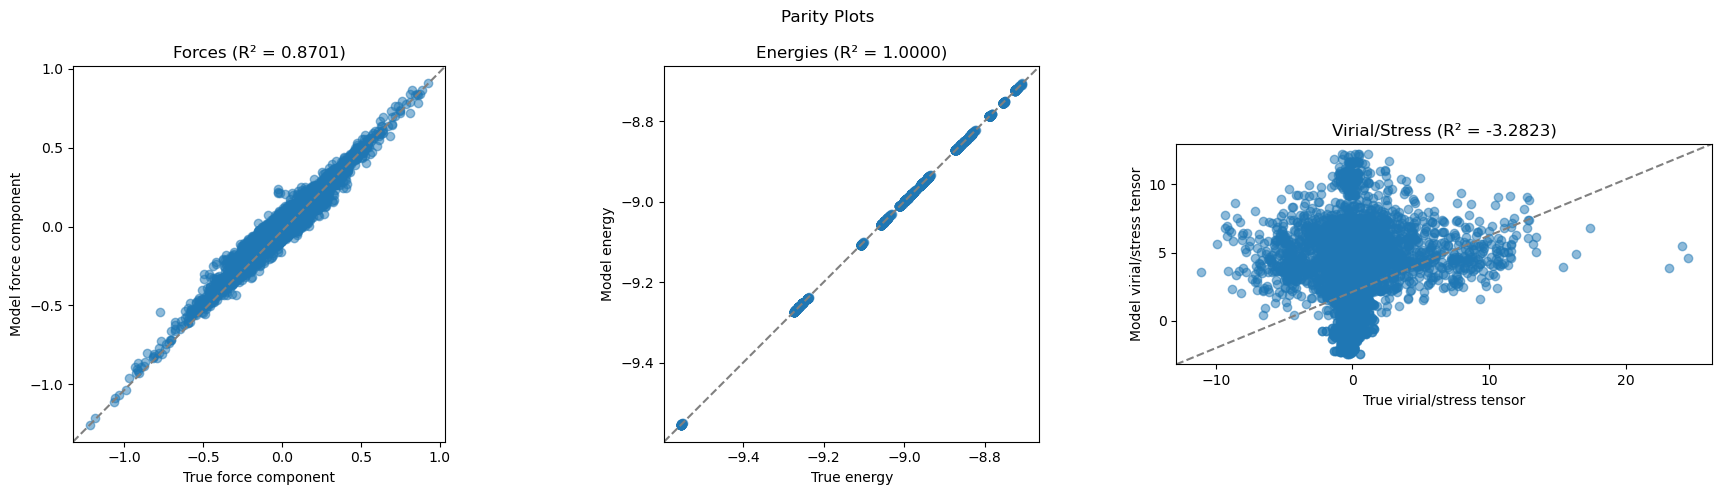

In [32]:

# Calculate R^2 values
r2_forces = r2_score(new_true_forces, new_forces)
r2_energies = r2_score(new_true_energies, new_energies)
r2_virials = r2_score(new_true_virials, new_virials) if virials is not None else None

# Determine the number of plots and figure size
if virials is not None:
    n_plots = 3
    fig_width = 18  # Increased width to accommodate all plots
else:
    n_plots = 2
    fig_width = 12

fig, axs = plt.subplots(ncols=n_plots, figsize=(fig_width, 5))

# Force plot
ax = axs[0]
ax.set_xlabel("True force component")
ax.set_ylabel("Model force component")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="gray")
ax.scatter(true_forces, forces, alpha=0.5)
ax.set_aspect("equal")
ax.set_title(f"Forces (R² = {r2_forces:.4f})")

# Energy plot
ax = axs[1]
ax.set_xlabel("True energy")
ax.set_ylabel("Model energy")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="gray")
ax.scatter(true_energies, energies, alpha=0.5)
ax.set_aspect("equal")
ax.set_title(f"Energies (R² = {r2_energies:.4f})")

# Virial/Stress plot
if virials is not None:
    ax = axs[2]
    ax.set_xlabel("True virial/stress tensor")
    ax.set_ylabel("Model virial/stress tensor")
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="gray")
    ax.scatter(true_virials, virials, alpha=0.5)
    ax.set_aspect("equal")
    ax.set_title(f"Virial/Stress (R² = {r2_virials:.4f})")

    # Use scientific notation for axis labels
    ax.ticklabel_format(style='sci', scilimits=(-2,2), axis='both')

    # Adjust tick frequency
    ax.locator_params(axis='both', nbins=5)

plt.suptitle("Parity Plots")
plt.tight_layout()

plt.show()

## Compare the RDF with Mace

In [6]:
from pymatgen.io.vasp import Xdatcar
from pymatgen.core import Structure, Lattice

# load in the initial structure 
job_name ='supercell_gen0_comp10_struct1_vac_site0_start'
initial_structure = Structure.from_file(f'../Archived_Vasp_Jobs/Vacancies/{job_name}/POSCAR')
xdatcar = Xdatcar(f'../Archived_Vasp_Jobs/VCrTiWZr_Summit/Vacancies/Post_VASP/{job_name}/XDATCAR-2')
final_structure_vasp = xdatcar.structures[-1]

In [8]:
from ase.optimize import LBFGS, FIRE, BFGS, MDMin, QuasiNewton
from mace.calculators import MACECalculator
def mace_relaxer(atoms, model_path, fmax = 0.01, steps = 250, relax_cell=True, optimizer = 'LBFGS', device='cpu'):
    if isinstance(atoms, Structure):
        atoms = AseAtomsAdaptor.get_atoms(atoms)
    new_atoms = atoms.copy()
    new_atoms.calc = MACECalculator(model_paths=[model_path], device=device, default_dtype="float32")

    if relax_cell:
        ucf = FrechetCellFilter(new_atoms)
        #obs = TrajectoryObserver(ucf)
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #optimizer.attach(obs, interval=loginterval)

    else:
        #constraints = FixAtoms(mask=[False] * len(new_atoms))  # Allow all atoms to move
        # Add constraints to atoms
        #new_atoms.set_constraint(constraints)
        ucf = new_atoms
        if optimizer == 'LBFGS':
            optimizer = LBFGS(ucf)
        elif optimizer == 'BFGS':
            optimizer = BFGS(ucf)
        elif optimizer == 'MDMin':
            optimizer = MDMin(ucf)
        elif optimizer == 'QuasiNewton':
            optimizer = QuasiNewton(ucf)
        elif optimizer == 'FIRE':
            optimizer = FIRE(ucf)
        #obs = TrajectoryObserver(atoms)
        #optimizer.attach(obs, interval=loginterval)

    optimizer.run(fmax=fmax, steps=steps)
    return new_atoms

# now get final structure frim mace 
final_structure_mace = AseAtomsAdaptor.get_structure(mace_relaxer(AseAtomsAdaptor.get_atoms(initial_structure), 
                                    model_path= '../Potentials/Mace/vcrtiwzr_vac_stress_e1_f10_s100_stagetwo_compiled.model',
                                    fmax=0.01, 
                                    steps=1000, 
                                    relax_cell=False, 
                                    optimizer='FIRE'))

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


      Step     Time          Energy          fmax
FIRE:    0 17:24:33     -561.163818        1.360469
FIRE:    1 17:24:35     -561.215759        1.337611
FIRE:    2 17:24:36     -561.312805        1.292281
FIRE:    3 17:24:37     -561.443298        1.221944
FIRE:    4 17:24:38     -561.592651        1.100573
FIRE:    5 17:24:38     -561.742188        0.888939
FIRE:    6 17:24:39     -561.869934        0.623847
FIRE:    7 17:24:40     -561.966064        0.407572
FIRE:    8 17:24:40     -562.038025        0.269915
FIRE:    9 17:24:41     -562.080627        0.359959
FIRE:   10 17:24:42     -562.101501        0.395452
FIRE:   11 17:24:43     -562.106384        0.385869
FIRE:   12 17:24:43     -562.115601        0.366977
FIRE:   13 17:24:44     -562.128296        0.339328
FIRE:   14 17:24:45     -562.143311        0.303748
FIRE:   15 17:24:46     -562.159241        0.261342
FIRE:   16 17:24:46     -562.174622        0.213541
FIRE:   17 17:24:47     -562.188293        0.162322
FIRE:   18 17:

In [9]:
vasp_indices_v = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'V']
vasp_indices_cr = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Cr']
vasp_indices_ti = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Ti']
vasp_indices_w = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'W']
vasp_indices_zr = [i for i, site in enumerate(final_structure_vasp) if site.species_string == 'Zr']

mace_indices_v = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'V']
mace_indices_cr = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Cr']
mace_indices_ti = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Ti']
mace_indices_w = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'W']
mace_indices_zr = [i for i, site in enumerate(final_structure_mace) if site.species_string == 'Zr']

In [12]:
from vasppy.rdf import RadialDistributionFunction


vasp_rdf_vv = RadialDistributionFunction(structures=[final_structure_vasp],
                                      indices_i=vasp_indices_v)
vasp_rdf_crcr = RadialDistributionFunction(structures=[final_structure_vasp],
                                      indices_i=vasp_indices_cr)
vasp_rdf_titi = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_ti)
vasp_rdf_ww = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_w)
vasp_rdf_zrzr = RadialDistributionFunction(structures=[final_structure_vasp],
                                        indices_i=vasp_indices_zr)

mace_rdf_vv = RadialDistributionFunction(structures=[final_structure_mace],
                                      indices_i=mace_indices_v)
mace_rdf_crcr = RadialDistributionFunction(structures=[final_structure_mace],
                                      indices_i=mace_indices_cr)
mace_rdf_titi = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_ti)
mace_rdf_ww = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_w)
mace_rdf_zrzr = RadialDistributionFunction(structures=[final_structure_mace],
                                        indices_i=mace_indices_zr)

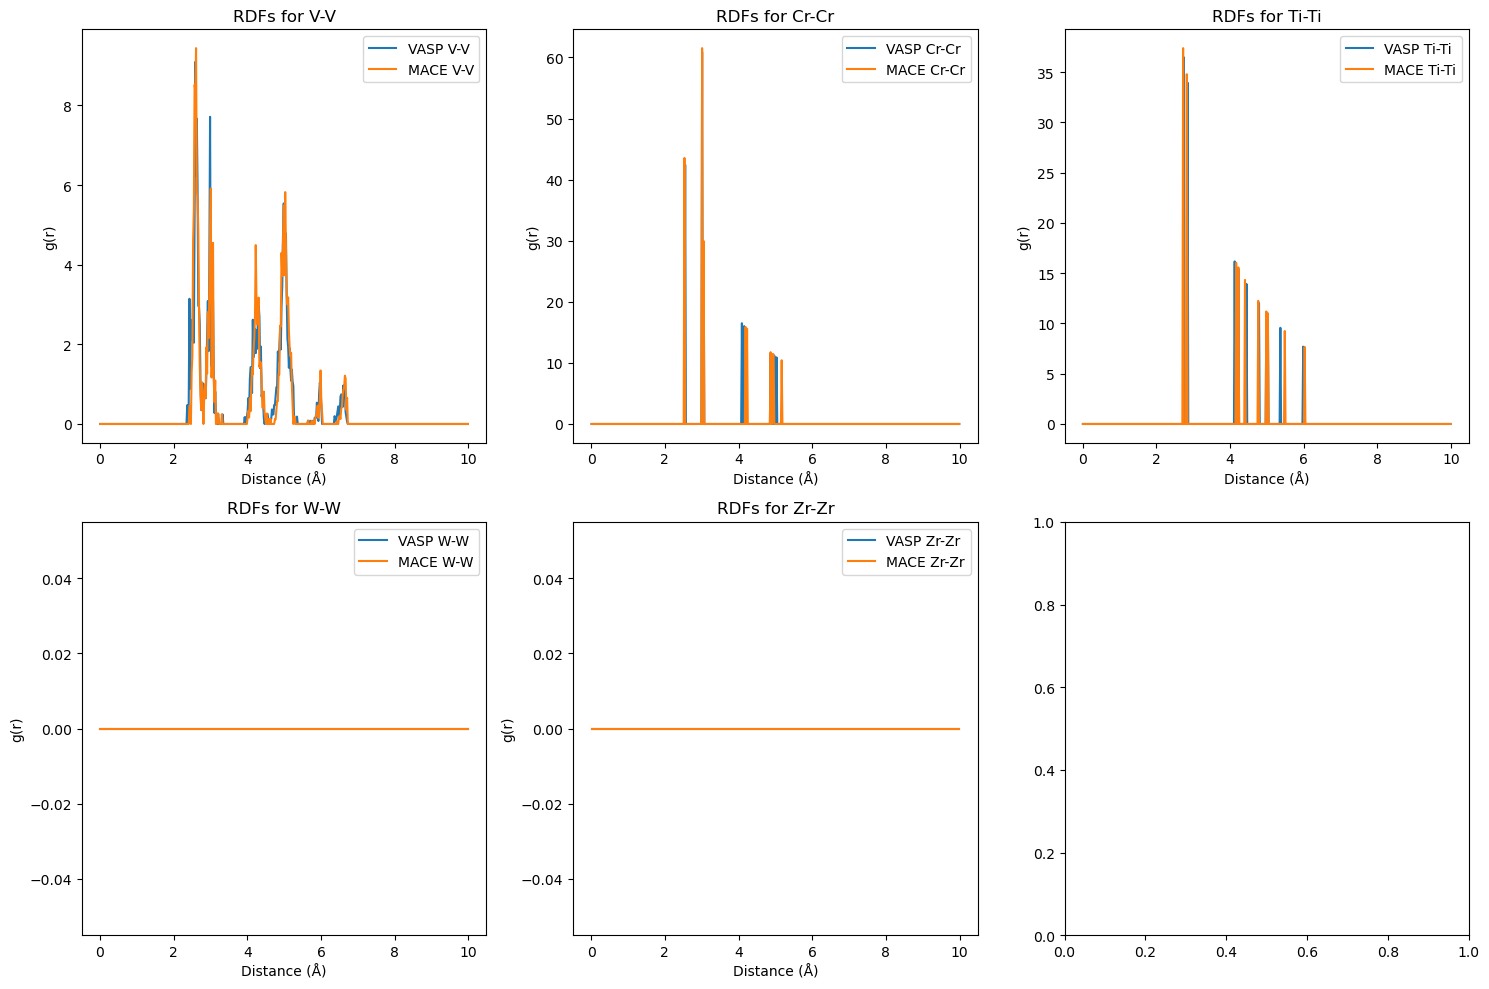

In [18]:
import matplotlib.pyplot as plt
labels = ['V-V', 'Cr-Cr', 'Ti-Ti', 'W-W', 'Zr-Zr']
# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Plot RDFs for each element pair
for i, label in enumerate(labels):
    # Determine the subplot position
    row = i // 3
    col = i % 3
    
    # Select the subplot
    ax = axs[row, col]
    
    # Set the subplot title and labels
    ax.set_title(f"RDFs for {label}")
    ax.set_xlabel("Distance (Å)")
    ax.set_ylabel("g(r)")
    
    # Plot VASP RDF
    if label == 'V-V':
        ax.plot(vasp_rdf_vv.r, vasp_rdf_vv.rdf, label="VASP V-V")
    elif label == 'Cr-Cr':
        ax.plot(vasp_rdf_crcr.r, vasp_rdf_crcr.rdf, label="VASP Cr-Cr")
    elif label == 'Ti-Ti':
        ax.plot(vasp_rdf_titi.r, vasp_rdf_titi.rdf, label="VASP Ti-Ti")
    elif label == 'W-W':
        ax.plot(vasp_rdf_ww.r, vasp_rdf_ww.rdf, label="VASP W-W")
    elif label == 'Zr-Zr':
        ax.plot(vasp_rdf_zrzr.r, vasp_rdf_zrzr.rdf, label="VASP Zr-Zr")
    
    # Plot MACE RDF
    if label == 'V-V':
        ax.plot(mace_rdf_vv.r, mace_rdf_vv.rdf, label="MACE V-V")
    elif label == 'Cr-Cr':
        ax.plot(mace_rdf_crcr.r, mace_rdf_crcr.rdf, label="MACE Cr-Cr")
    elif label == 'Ti-Ti':
        ax.plot(mace_rdf_titi.r, mace_rdf_titi.rdf, label="MACE Ti-Ti")
    elif label == 'W-W':
        ax.plot(mace_rdf_ww.r, mace_rdf_ww.rdf, label="MACE W-W")
    elif label == 'Zr-Zr':
        ax.plot(mace_rdf_zrzr.r, mace_rdf_zrzr.rdf, label="MACE Zr-Zr")
    
    # Add legend to the subplot
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()